# **Imports and other dependencies**

In [ ]:
!pip install catboost
!pip install pmdarima
!pip install shap
!pip install tabulate
!pip install prophet

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from tabulate import tabulate
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, StackingRegressor
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model, naive_bayes, gaussian_process
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import shap

from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
from prophet import Prophet


#**Q-1 Weather Forecasting - Machine Learning Notebook**

## Loading, Inspecting and Identifying Data

In [82]:
# Load Dataset
df = pd.read_csv("weather_data.csv")
df.head()

date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0  2023-01-01        23.745401  46.140905        7.845981        Rain   
1  2023-01-02        30.030503  59.876587        5.382457        Rain   
2  2023-01-03        28.365224  51.464618       13.158008        Rain   
3  2023-01-04        27.550929  53.103799        5.886677        Rain   
4  2023-01-05        23.639303  57.826186       12.248992        Rain   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331

In [83]:
# Check structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 4   rain_or_not      311 non-null    object 
 5   cloud_cover      296 non-null    float64
 6   pressure         311 non-null    float64
dtypes: float64(5), object(2)
memory usage: 17.1+ KB


In [84]:
# Convert 'Date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])
df


date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0   2023-01-01        23.745401  46.140905        7.845981        Rain   
1   2023-01-02        30.030503  59.876587        5.382457        Rain   
2   2023-01-03        28.365224  51.464618       13.158008        Rain   
3   2023-01-04        27.550929  53.103799        5.886677        Rain   
4   2023-01-05        23.639303  57.826186       12.248992        Rain   
..         ...              ...        ...             ...         ...   
306 2023-11-03        22.072834  37.756910        4.729355     No Rain   
307 2023-11-04        19.645885  42.190604        8.092369     No Rain   
308 2023-11-05        23.884496  36.205508       11.860847        Rain   
309 2023-11-06        18.168418  34.785000        4.781288     No Rain   
310 2023-11-07        19.389714  37.717416        9.388371     No Rain   

     cloud_cover     pressure  
0      20.851051   992.965681  
1      93.059521  1037.273025  
2      11.636640  1034.193357  
3      81.744971   968.610142  
4      38.062329  1030.264331  
..           ...          ...  
306    27.307081   954.564875  
307    51.807877   964.002410  
308    29.872557   977.681431  
309    94.067925  1047.153269  
310    25.929676   983.134701  

[311 rows x 7 columns]

In [85]:
# Check if dates are in order
dates_in_order = df['date'].is_monotonic_increasing

if dates_in_order:
  print("Dates are in chronological order.")
else:
  print("Dates are not in chronological order.")


Dates are in chronological order.


In [86]:
# Calculate and print the number of missing values for each column
print(df.isnull().sum())

date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64


In [87]:
missing_values = df[df.isnull().any(axis=1)]
print(missing_values)

          date  avg_temperature  humidity  avg_wind_speed rain_or_not  \
12  2023-01-13              NaN       NaN             NaN     No Rain   
15  2023-01-16              NaN       NaN             NaN        Rain   
16  2023-01-17              NaN       NaN             NaN     No Rain   
44  2023-02-14              NaN       NaN             NaN        Rain   
47  2023-02-17              NaN       NaN             NaN        Rain   
52  2023-02-22              NaN       NaN             NaN     No Rain   
57  2023-02-27              NaN       NaN             NaN        Rain   
71  2023-03-13              NaN       NaN             NaN     No Rain   
111 2023-04-22              NaN       NaN             NaN        Rain   
114 2023-04-25              NaN       NaN             NaN        Rain   
125 2023-05-06              NaN       NaN             NaN        Rain   
140 2023-05-21              NaN       NaN             NaN        Rain   
216 2023-08-05              NaN       NaN          

Note: For a given date, rain_or_not and pressure, in 15 rows, the other data are missing.

They have been extracted and stored in the missing_values dataframe

## Preprocessing

### Handling Missing Values
Imputation can be done in several ways for Time Series datasets.
- Interpolation (Time-Series Based)
- K-Nearest Neighbors (KNN) Imputation
- Rolling Mean Imputation
- Rolling Median Imputation
- Exponentially Weighted Moving Average (EWMA) Imputation

*(KNN has bee used for the moment)*

In [11]:
imputer = KNNImputer(n_neighbors=5)
df[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']] = imputer.fit_transform(df[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']])


In [12]:
print(df.isnull().sum())

date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
dtype: int64


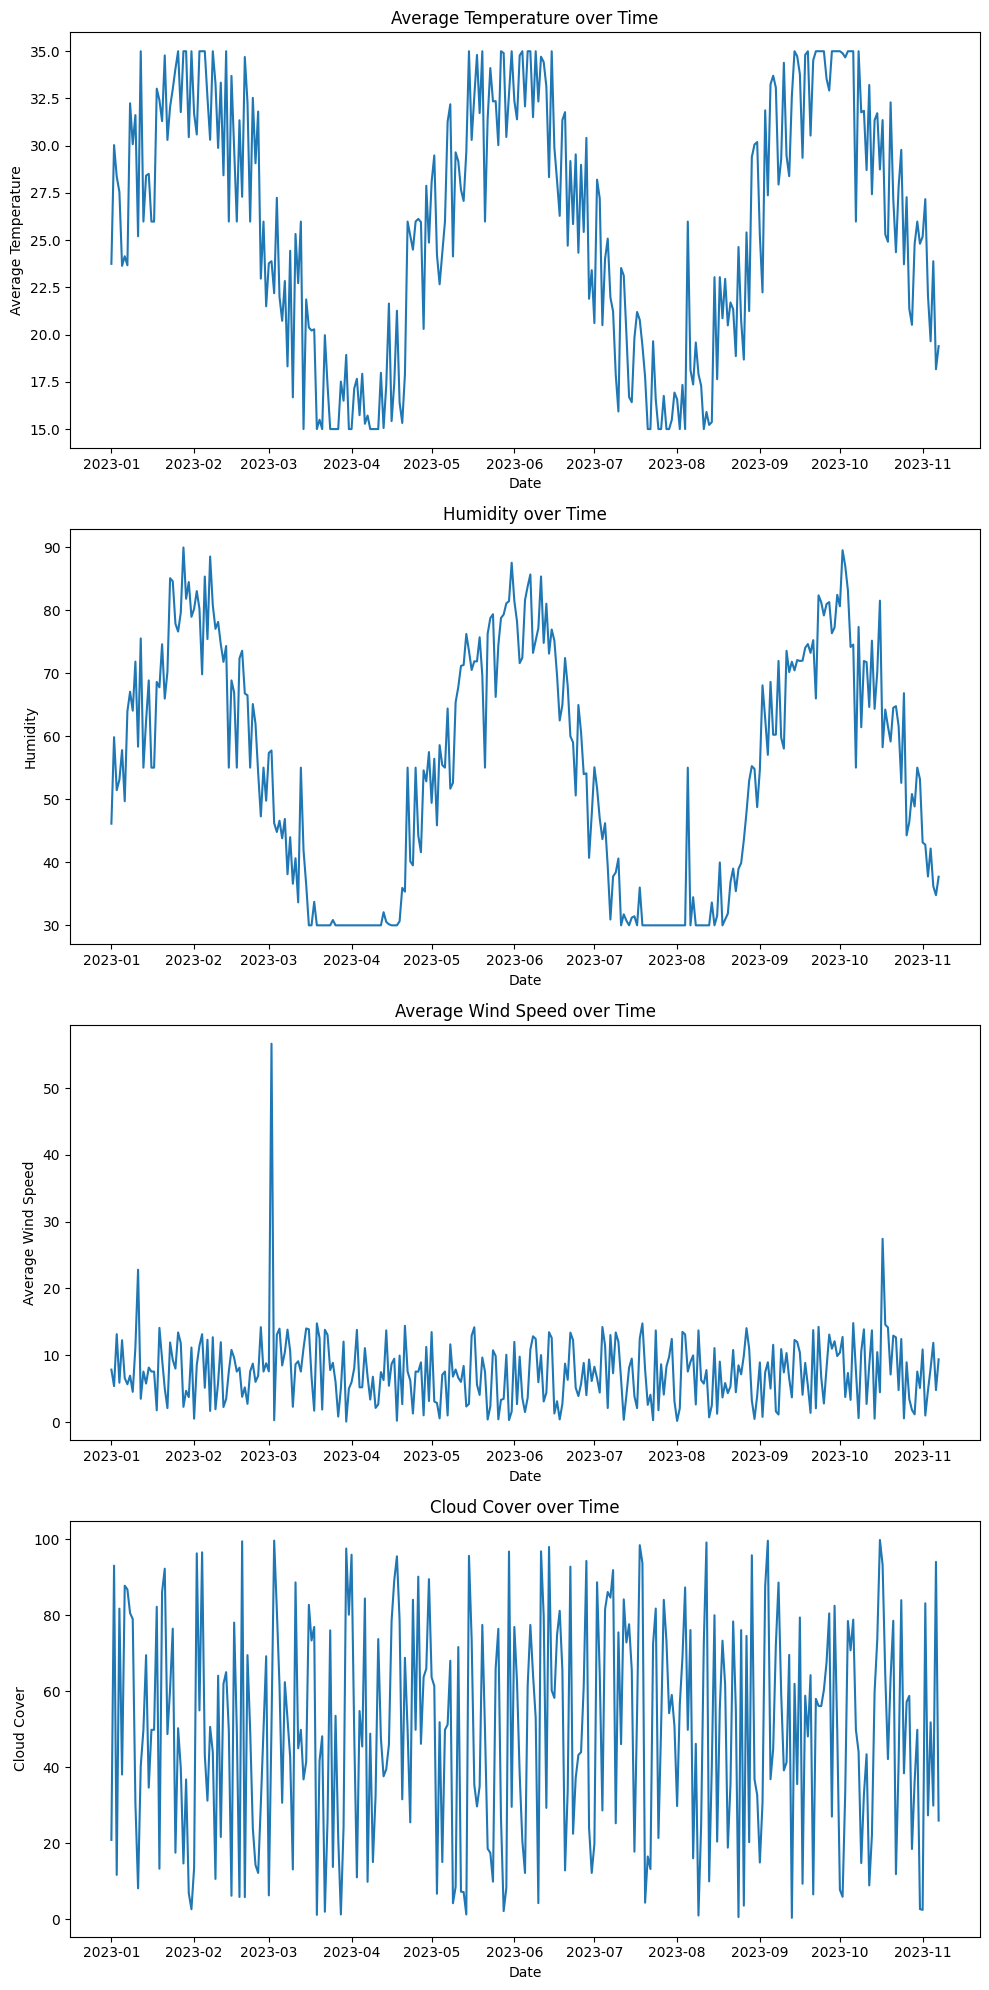

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

# Plotting 'avg_temperature'
axes[0].plot(df['date'], df['avg_temperature'])
axes[0].set_title('Average Temperature over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Average Temperature')


# Plotting 'humidity'
axes[1].plot(df['date'], df['humidity'])
axes[1].set_title('Humidity over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Humidity')


# Plotting 'avg_wind_speed'
axes[2].plot(df['date'], df['avg_wind_speed'])
axes[2].set_title('Average Wind Speed over Time')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Average Wind Speed')


# Plotting 'cloud_cover'
axes[3].plot(df['date'], df['cloud_cover'])
axes[3].set_title('Cloud Cover over Time')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Cloud Cover')

plt.tight_layout()
plt.show()


## Feature Engineering

In [14]:
# Convert 'rain_or_not' to binary (0 = No Rain, 1 = Rain)
df["rain_or_not"] = df["rain_or_not"].map({"Rain": 1, "No Rain": 0})
df.head()


date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0 2023-01-01        23.745401  46.140905        7.845981            1   
1 2023-01-02        30.030503  59.876587        5.382457            1   
2 2023-01-03        28.365224  51.464618       13.158008            1   
3 2023-01-04        27.550929  53.103799        5.886677            1   
4 2023-01-05        23.639303  57.826186       12.248992            1   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331

### Outlier Detection

#### Box Plots

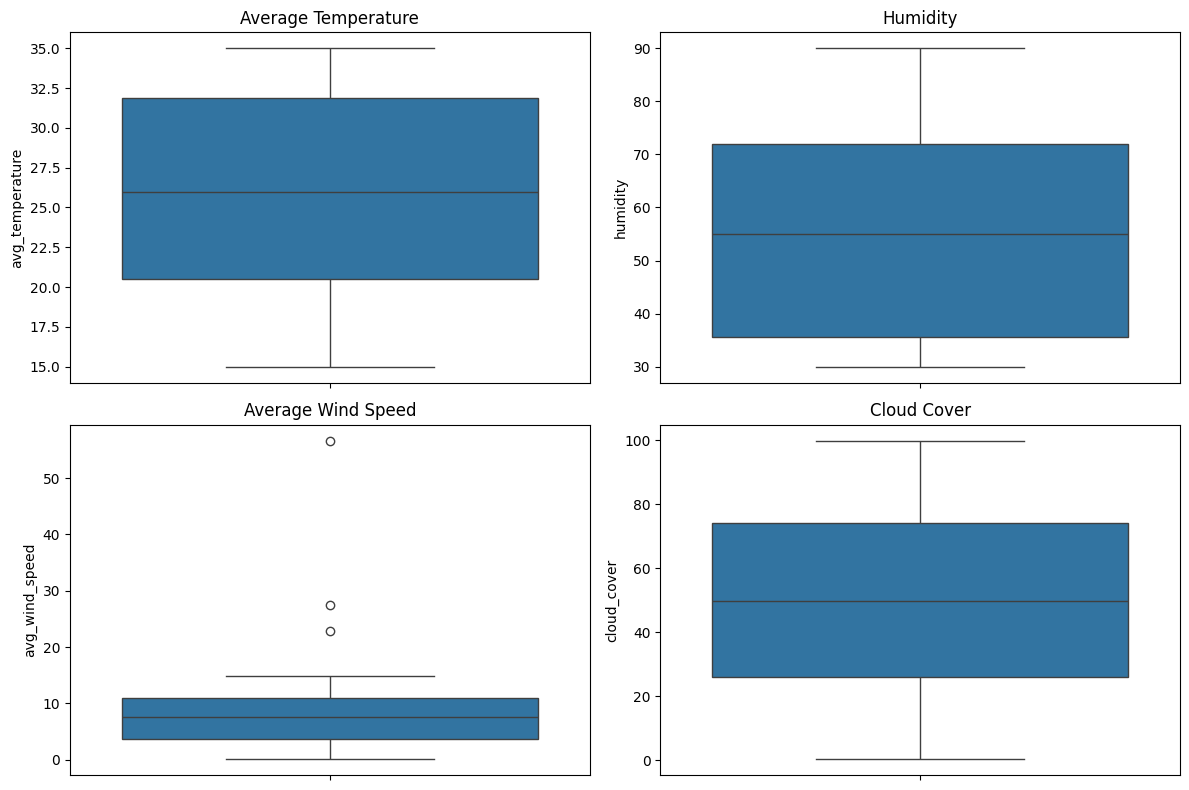

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot each box plot
sns.boxplot(ax=axes[0, 0], y=df['avg_temperature'])
axes[0, 0].set_title('Average Temperature')

sns.boxplot(ax=axes[0, 1], y=df['humidity'])
axes[0, 1].set_title('Humidity')

sns.boxplot(ax=axes[1, 0], y=df['avg_wind_speed'])
axes[1, 0].set_title('Average Wind Speed')

sns.boxplot(ax=axes[1, 1], y=df['cloud_cover'])
axes[1, 1].set_title('Cloud Cover')

plt.tight_layout()
plt.show()

In [16]:
# Identify outliers using the IQR method for each column
for col in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Outliers for {col}:\n{outliers[[col, 'date']]}") # Print date along with outlier values
    print("-" * 20)


Outliers for avg_temperature:
Empty DataFrame
Columns: [avg_temperature, date]
Index: []
--------------------
Outliers for humidity:
Empty DataFrame
Columns: [humidity, date]
Index: []
--------------------
Outliers for avg_wind_speed:
     avg_wind_speed       date
10        22.803513 2023-01-11
60        56.636041 2023-03-02
289       27.430920 2023-10-17
--------------------
Outliers for cloud_cover:
Empty DataFrame
Columns: [cloud_cover, date]
Index: []
--------------------


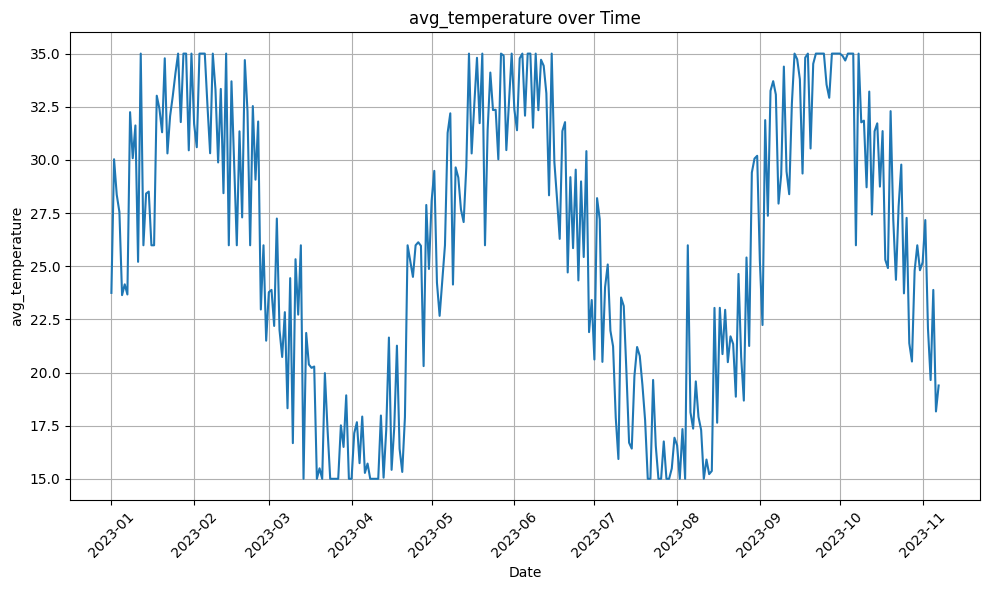

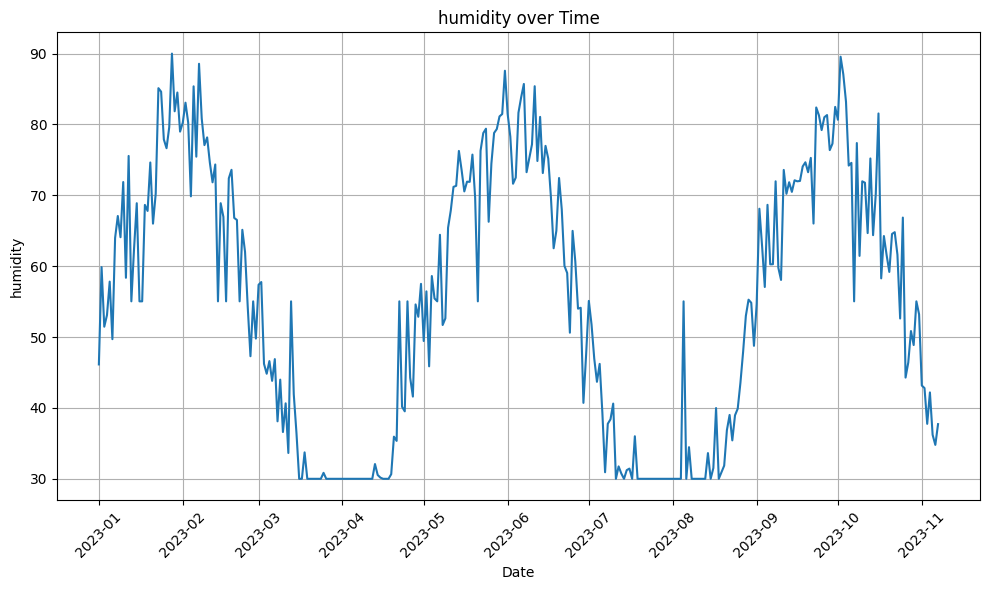

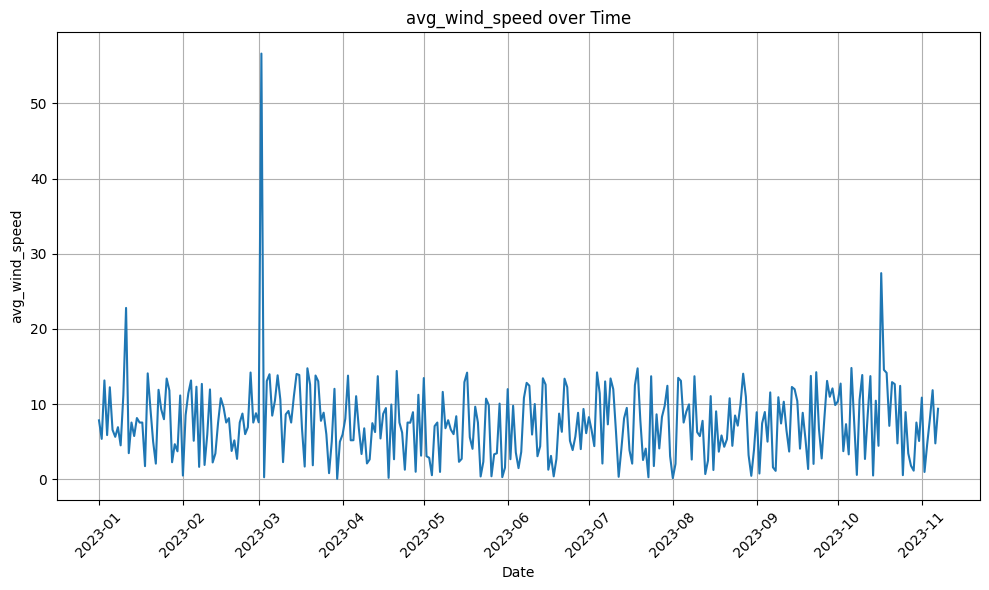

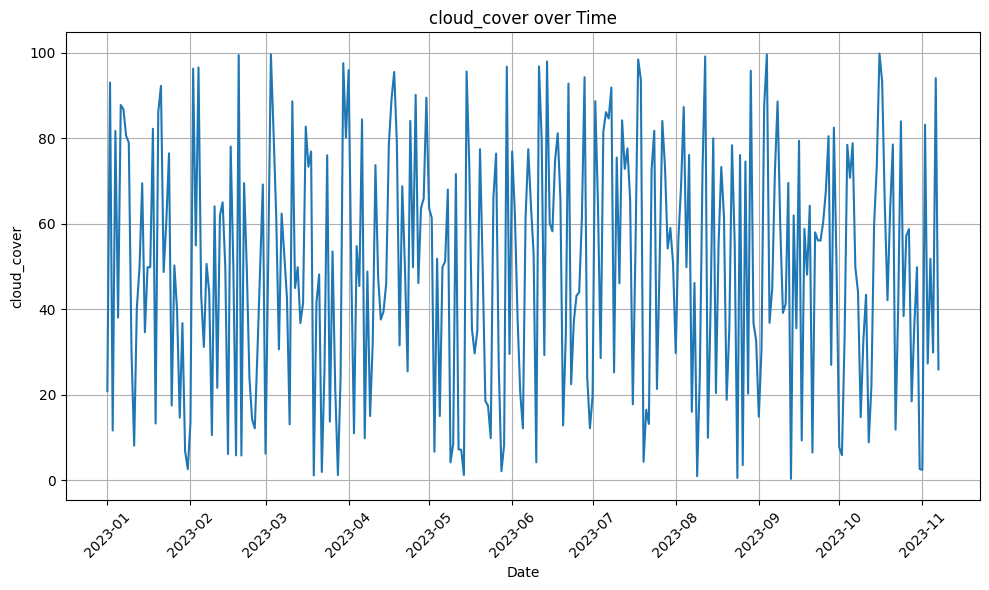

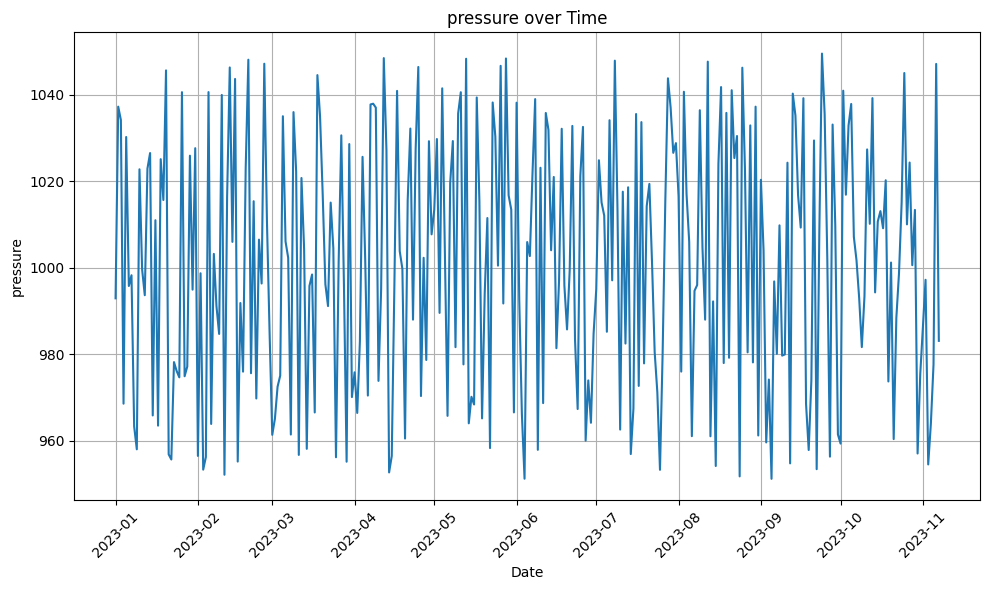

In [17]:
# Plotting each column against 'date'
for column in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df[column])
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(f'{column} over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### After seasonal decomposition

In [18]:
for col in ['cloud_cover']:
    # Seasonal decomposition
    decomposed = seasonal_decompose(df[col], model='additive', period=7)
    # Extract residuals and detect outliers
    residual_outliers = np.abs(decomposed.resid) > (3 * decomposed.resid.std())
    # Display detected outliers
    print(f"Outliers for {col}:")
    print(df[residual_outliers])
    print("-" * 20)

for col in ['avg_temperature', 'humidity', 'avg_wind_speed']:
    # Seasonal decomposition
    decomposed = seasonal_decompose(df[col], model='additive', period=30)
    # Extract residuals and detect outliers
    residual_outliers = np.abs(decomposed.resid) > (3 * decomposed.resid.std())
    # Display detected outliers
    print(f"Outliers for {col}:")
    print(df[residual_outliers])
    print("-" * 20)


Outliers for cloud_cover:
Empty DataFrame
Columns: [date, avg_temperature, humidity, avg_wind_speed, rain_or_not, cloud_cover, pressure]
Index: []
--------------------
Outliers for avg_temperature:
Empty DataFrame
Columns: [date, avg_temperature, humidity, avg_wind_speed, rain_or_not, cloud_cover, pressure]
Index: []
--------------------
Outliers for humidity:
          date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
216 2023-08-05         25.98384  55.041385        7.556636            0   

     cloud_cover     pressure  
216    49.834827  1006.044063  
--------------------
Outliers for avg_wind_speed:
          date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
60  2023-03-02        23.886773  57.764299       56.636041            1   
289 2023-10-17        31.354723  58.284143       27.430920            1   

     cloud_cover     pressure  
60     50.942213   965.124683  
289    93.311333  1009.169716  
--------------------


Handling Humidity outliers

In [19]:
target_date = pd.to_datetime('2023-08-05')

# Finding the row corresponding to the target date
row_index = df.index[df['date'] == target_date]

# Setting the humidity value to NaN (empty) for that date
if not row_index.empty:
    df.loc[row_index, 'humidity'] = np.nan
    print(f"Humidity value for {target_date} set to empty.")
else:
    print(f"Date {target_date} not found in the DataFrame.")


Humidity value for 2023-08-05 00:00:00 set to empty.


In [20]:
target_date = pd.to_datetime('2023-08-05')

# Finding the row corresponding to the target date
row_index = df.index[df['date'] == target_date]

# Print the entire row
if not row_index.empty:
    print(df.loc[row_index])
else:
    print(f"Date {target_date} not found in the DataFrame.")


          date  avg_temperature  humidity  avg_wind_speed  rain_or_not  \
216 2023-08-05         25.98384       NaN        7.556636            0   

     cloud_cover     pressure  
216    49.834827  1006.044063  


Handling avg_wind_speed outliers

In [21]:
target_dates = [pd.to_datetime('2023-03-02'), pd.to_datetime('2023-10-17')]

for target_date in target_dates:
    # Finding the row corresponding to the target date
    row_index = df.index[df['date'] == target_date]

    # Setting the avg_wind_speed value to NaN (empty) for that date
    if not row_index.empty:
        df.loc[row_index, 'avg_wind_speed'] = np.nan
        print(f"avg_wind_speed value for {target_date} set to empty.")
    else:
        print(f"Date {target_date} not found in the DataFrame.")

avg_wind_speed value for 2023-03-02 00:00:00 set to empty.
avg_wind_speed value for 2023-10-17 00:00:00 set to empty.


Imputing Values

In [22]:
# Impute missing values using linear interpolation
df[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']] = df[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']].interpolate(method='linear')


In [23]:
target_dates = [pd.to_datetime('2023-03-02'), pd.to_datetime('2023-08-05'), pd.to_datetime('2023-10-17')]

for target_date in target_dates:
    row_index = df.index[df['date'] == target_date]
    if not row_index.empty:
        print(df.loc[row_index])
    else:
        print(f"Date {target_date} not found in the DataFrame.")

         date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
60 2023-03-02        23.886773  57.764299        3.929991            1   

    cloud_cover    pressure  
60    50.942213  965.124683  
          date  avg_temperature  humidity  avg_wind_speed  rain_or_not  \
216 2023-08-05         25.98384      30.0        7.556636            0   

     cloud_cover     pressure  
216    49.834827  1006.044063  
          date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
289 2023-10-17        31.354723  58.284143        9.513054            1   

     cloud_cover     pressure  
289    93.311333  1009.169716  


In [24]:
print(df.isnull().sum())
missing_values = df[df.isnull().any(axis=1)]
missing_values

date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
dtype: int64


Empty DataFrame
Columns: [date, avg_temperature, humidity, avg_wind_speed, rain_or_not, cloud_cover, pressure]
Index: []

Creating a copy of the preprocessed dataframe

In [25]:
preprocessed_df= df.copy()
preprocessed_df.head()

date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0 2023-01-01        23.745401  46.140905        7.845981            1   
1 2023-01-02        30.030503  59.876587        5.382457            1   
2 2023-01-03        28.365224  51.464618       13.158008            1   
3 2023-01-04        27.550929  53.103799        5.886677            1   
4 2023-01-05        23.639303  57.826186       12.248992            1   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331

In [26]:
preprocessed_df.to_csv('preprocessed_weather_data.csv', index=False)

## Model 1: Building a model to predict rain_or_not

In [27]:
model_1_df=preprocessed_df.copy()

In [28]:
warnings.filterwarnings("ignore")

copy_df = preprocessed_df.copy()
if "date" in copy_df.columns:
    copy_df.drop(columns=["date"], inplace=True)

X = copy_df.drop(columns=["rain_or_not"])
y = copy_df["rain_or_not"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": linear_model.LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "SVM (Linear Kernel)": SVC(kernel='linear', random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),  # Suppress warnings
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),  # Suppress output
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    "Gaussian Process Classifier": gaussian_process.GaussianProcessClassifier(),
    "Logistic Regression CV": linear_model.LogisticRegressionCV(),
    "Passive Aggressive Classifier": linear_model.PassiveAggressiveClassifier(),
    "Ridge Classifier CV": linear_model.RidgeClassifierCV(),
    "SGD Classifier": linear_model.SGDClassifier(),
    "Perceptron": linear_model.Perceptron(),
    "Bernoulli NB": naive_bayes.BernoulliNB(),
    "Gaussian NB": naive_bayes.GaussianNB(),
}

# Train and evaluate models
best_model = None
best_accuracy = 0
results = {}

for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name}: Accuracy = {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = name
    except Exception as e:
        print(f" {name} failed to train: {e}")

sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

print("\n **Model Performance Summary**")
for model, acc in sorted_results.items():
    print(f"{model}: {acc:.4f}")

print(f"\n **Best Model: {best_model} with Accuracy: {best_accuracy:.4f}**")


Logistic Regression: Accuracy = 0.6667
Decision Tree: Accuracy = 0.5079
Random Forest: Accuracy = 0.5714
Gradient Boosting: Accuracy = 0.4921
AdaBoost: Accuracy = 0.5079
Extra Trees: Accuracy = 0.5714
SVM (Linear Kernel): Accuracy = 0.6349
SVM (RBF Kernel): Accuracy = 0.6508
K-Nearest Neighbors: Accuracy = 0.6032
XGBoost: Accuracy = 0.5714
LightGBM: Accuracy = 0.6032
CatBoost: Accuracy = 0.6349
Neural Network (MLP): Accuracy = 0.5079
Gaussian Process Classifier: Accuracy = 0.6508
Logistic Regression CV: Accuracy = 0.6667
Passive Aggressive Classifier: Accuracy = 0.5079
Ridge Classifier CV: Accuracy = 0.6825
SGD Classifier: Accuracy = 0.5079
Perceptron: Accuracy = 0.5238
Bernoulli NB: Accuracy = 0.6349
Gaussian NB: Accuracy = 0.5714

 **Model Performance Summary**
Ridge Classifier CV: 0.6825
Logistic Regression: 0.6667
Logistic Regression CV: 0.6667
SVM (RBF Kernel): 0.6508
Gaussian Process Classifier: 0.6508
SVM (Linear Kernel): 0.6349
CatBoost: 0.6349
Bernoulli NB: 0.6349
K-Nearest Ne

In [29]:
model_1_df.drop(columns=["date"], inplace=True)

# Define features and target
X = model_1_df.drop(columns=["rain_or_not"])
y = model_1_df["rain_or_not"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": clf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(tabulate(feature_importance, headers="keys", tablefmt="grid"))

+----+-----------------+--------------+
|    | Feature         |   Importance |
+====+=================+==============+
|  2 | avg_wind_speed  |     0.264115 |
+----+-----------------+--------------+
|  1 | humidity        |     0.210432 |
+----+-----------------+--------------+
|  4 | pressure        |     0.20019  |
+----+-----------------+--------------+
|  0 | avg_temperature |     0.183424 |
+----+-----------------+--------------+
|  3 | cloud_cover     |     0.141839 |
+----+-----------------+--------------+


In [30]:
model_1_df=preprocessed_df.copy()

+-----------------+-----------------+-------------------+
|                 | Feature         |   SHAP Importance |
+=================+=================+===================+
| humidity        | humidity        |         0.200108  |
+-----------------+-----------------+-------------------+
| avg_wind_speed  | avg_wind_speed  |         0.178172  |
+-----------------+-----------------+-------------------+
| cloud_cover     | cloud_cover     |         0.0955053 |
+-----------------+-----------------+-------------------+
| avg_temperature | avg_temperature |         0.0829048 |
+-----------------+-----------------+-------------------+
| pressure        | pressure        |         0.0725688 |
+-----------------+-----------------+-------------------+


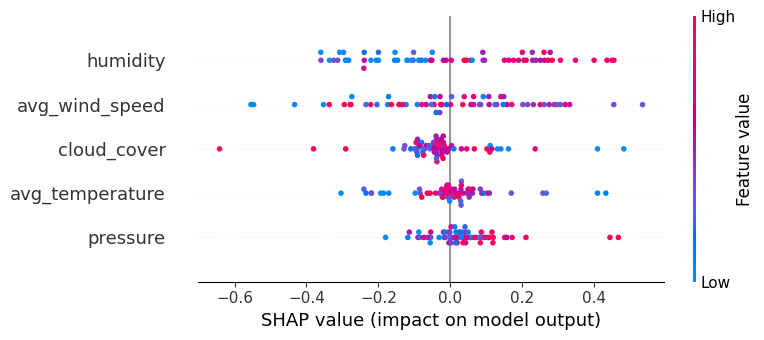

In [31]:
model_1_df.drop(columns=["date"], inplace=True)

X = model_1_df.drop(columns=["rain_or_not"])
y = model_1_df["rain_or_not"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Initialize SHAP Explainer
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

# Extract SHAP values for class 1
shap_class_1 = shap_values.values[:, :, 1]  # Take the second column (class 1)

shap_df = pd.DataFrame(shap_class_1, columns=X.columns)

shap_importance = pd.DataFrame({
    "Feature": X.columns,
    "SHAP Importance": shap_df.abs().mean()
}).sort_values(by="SHAP Importance", ascending=False)

print(tabulate(shap_importance, headers="keys", tablefmt="grid"))

shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X.columns)

All contribute hence, we will not be dropping columns

## Model 2: Finding the best Time-series model
1. SARIMA model to predict 21 days ahead
2. Prophet model to predict 21 days ahead
3. LSTM model to predict 21 days ahead
4. Stacking model to predict 21 days ahead

In [32]:
model_2_df=preprocessed_df.copy()
model_2_df.drop(columns=['rain_or_not'], inplace=True)
model_2_df

date  avg_temperature   humidity  avg_wind_speed  cloud_cover  \
0   2023-01-01        23.745401  46.140905        7.845981    20.851051   
1   2023-01-02        30.030503  59.876587        5.382457    93.059521   
2   2023-01-03        28.365224  51.464618       13.158008    11.636640   
3   2023-01-04        27.550929  53.103799        5.886677    81.744971   
4   2023-01-05        23.639303  57.826186       12.248992    38.062329   
..         ...              ...        ...             ...          ...   
306 2023-11-03        22.072834  37.756910        4.729355    27.307081   
307 2023-11-04        19.645885  42.190604        8.092369    51.807877   
308 2023-11-05        23.884496  36.205508       11.860847    29.872557   
309 2023-11-06        18.168418  34.785000        4.781288    94.067925   
310 2023-11-07        19.389714  37.717416        9.388371    25.929676   

        pressure  
0     992.965681  
1    1037.273025  
2    1034.193357  
3     968.610142  
4    1030.264331  
..           ...  
306   954.564875  
307   964.002410  
308   977.681431  
309  1047.153269  
310   983.134701  

[311 rows x 6 columns]

#### SARIMA Model
Picking the best seasonality time frame for weather attributes

Training SARIMA model for: avg_temperature


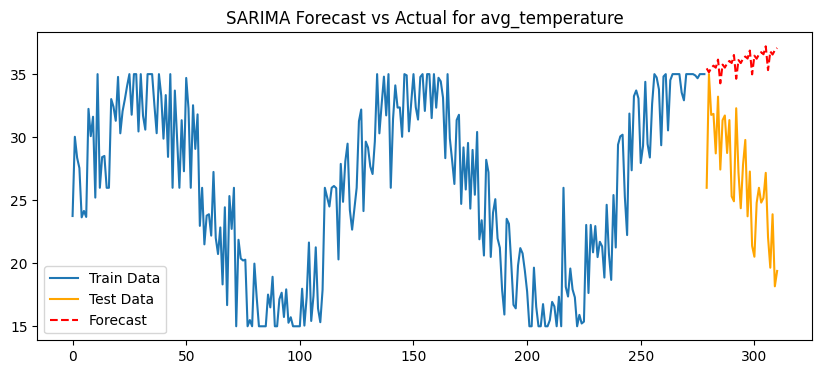

avg_temperature - MAE: 9.382, RMSE: 10.461, MAPE: 39.15%

Training SARIMA model for: humidity


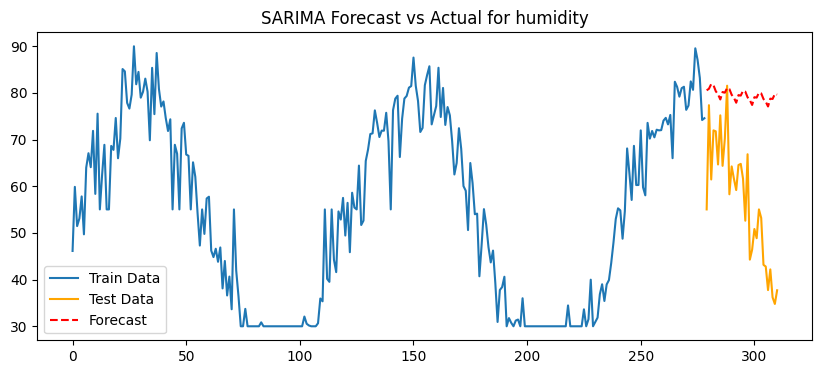

humidity - MAE: 22.694, RMSE: 25.678, MAPE: 47.40%

Training SARIMA model for: avg_wind_speed


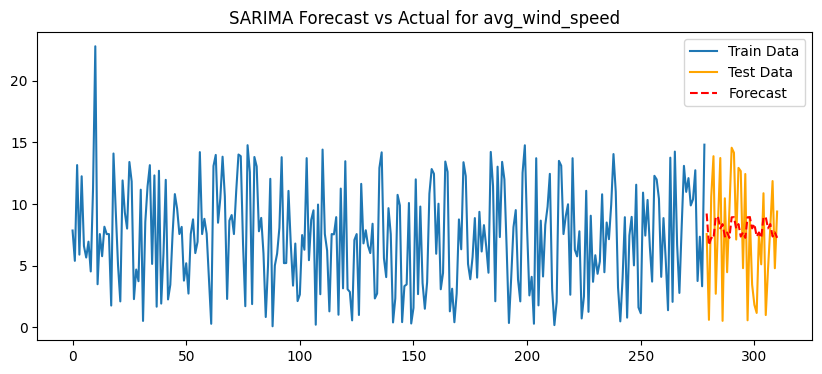

avg_wind_speed - MAE: 3.980, RMSE: 4.633, MAPE: 217.10%

Training SARIMA model for: cloud_cover


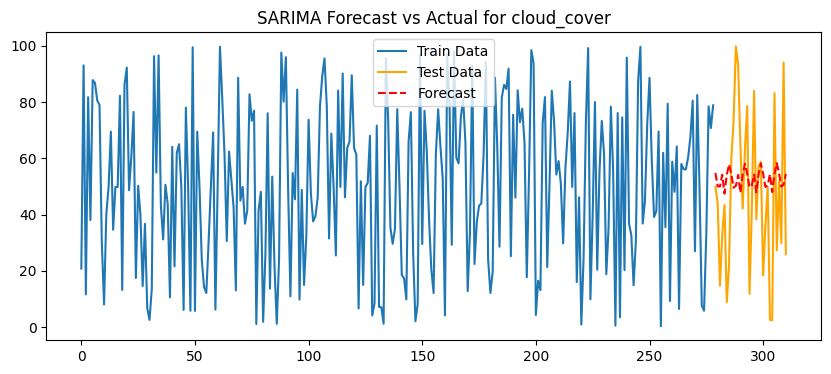

cloud_cover - MAE: 22.548, RMSE: 27.609, MAPE: 191.17%

Training SARIMA model for: pressure


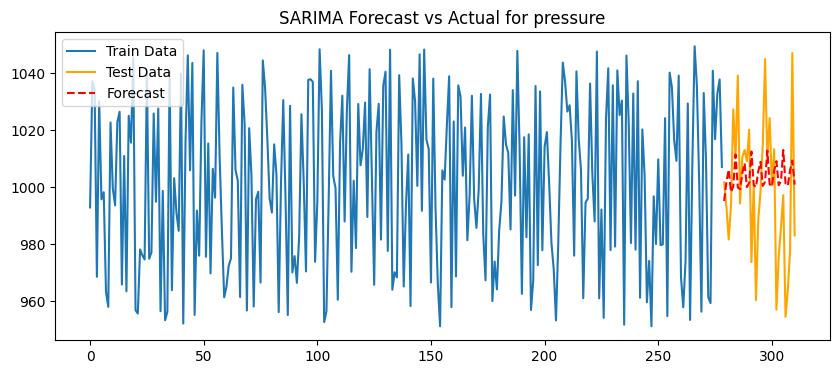

pressure - MAE: 19.698, RMSE: 24.770, MAPE: 1.98%

Final Model Errors:
 {'avg_temperature': {'MAE': 9.382312300208966, 'RMSE': 10.460989798300737, 'MAPE': 39.15470561896506}, 'humidity': {'MAE': 22.69364611251261, 'RMSE': 25.6781753523427, 'MAPE': 47.39793416396293}, 'avg_wind_speed': {'MAE': 3.979761435363697, 'RMSE': 4.632899509023888, 'MAPE': 217.10432399895342}, 'cloud_cover': {'MAE': 22.54804501101072, 'RMSE': 27.60888168819697, 'MAPE': 191.165352669689}, 'pressure': {'MAE': 19.697957518834198, 'RMSE': 24.769609858484127, 'MAPE': 1.982315737757468}}


In [36]:
warnings.filterwarnings("ignore")

columns = ["avg_temperature", "humidity", "avg_wind_speed", "cloud_cover", "pressure"]

order = (2, 1, 2)  # (p, d, q)
seasonal_order = (1, 1, 1, 7)  # (P, D, Q, s)

models = {}
errors = {}

for col in columns:
    print(f"Training SARIMA model for: {col}")

    train_size = int(len(model_2_df[col]) * 0.9)
    train, test = model_2_df[col][:train_size], model_2_df[col][train_size:]

    # Fit SARIMA model on training set
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_result = model.fit(disp=False)

    models[col] = sarima_result

    forecast = sarima_result.get_forecast(steps=len(test)).predicted_mean

    # Calculate errors
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = np.mean(np.abs((test - forecast) / test)) * 100  # Mean Absolute Percentage Error

    errors[col] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(train, label="Train Data")
    plt.plot(test, label="Test Data", color="orange")
    plt.plot(test.index, forecast, label="Forecast", linestyle="dashed", color="red")
    plt.title(f"SARIMA Forecast vs Actual for {col}")
    plt.legend()
    plt.show()

    # Print errors
    print(f"{col} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%\n")

# Print final error summary
print("Final Model Errors:\n", errors)


Training SARIMA model for: avg_temperature


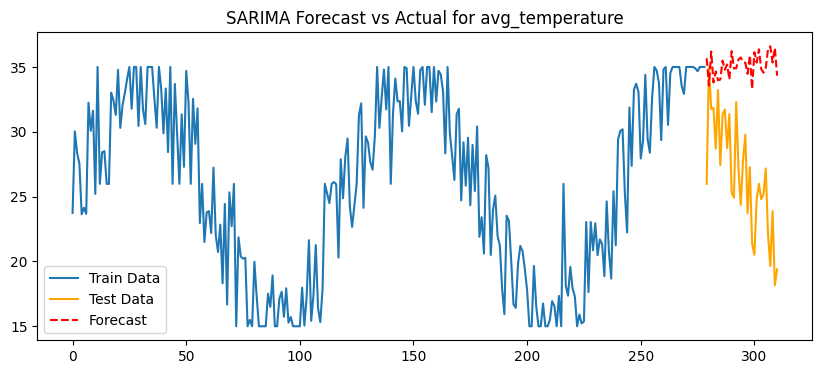

avg_temperature - MAE: 8.579, RMSE: 9.704, MAPE: 35.99%

Training SARIMA model for: humidity


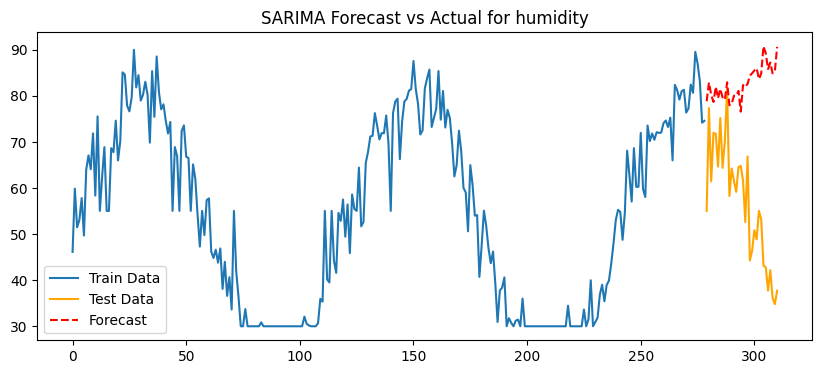

humidity - MAE: 25.909, RMSE: 30.090, MAPE: 54.81%

Training SARIMA model for: avg_wind_speed


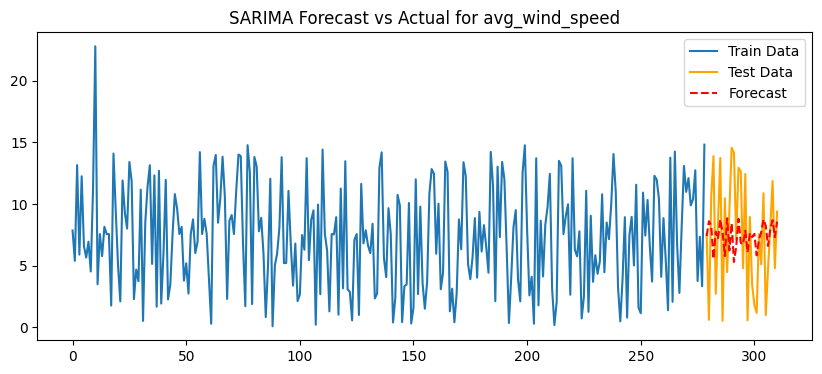

avg_wind_speed - MAE: 3.877, RMSE: 4.593, MAPE: 197.80%

Training SARIMA model for: cloud_cover


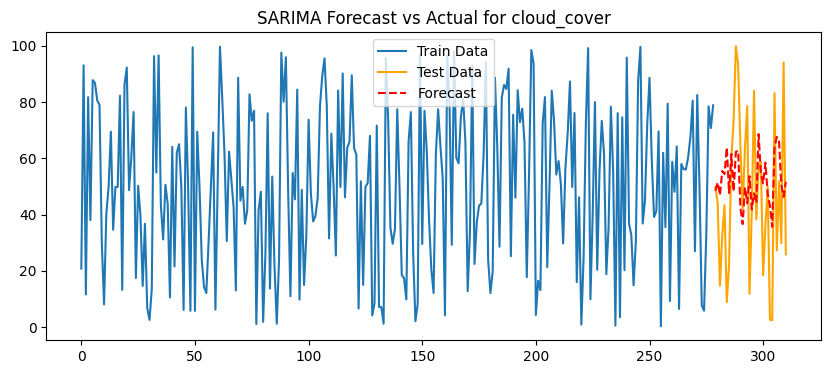

cloud_cover - MAE: 22.664, RMSE: 27.053, MAPE: 165.99%

Training SARIMA model for: pressure


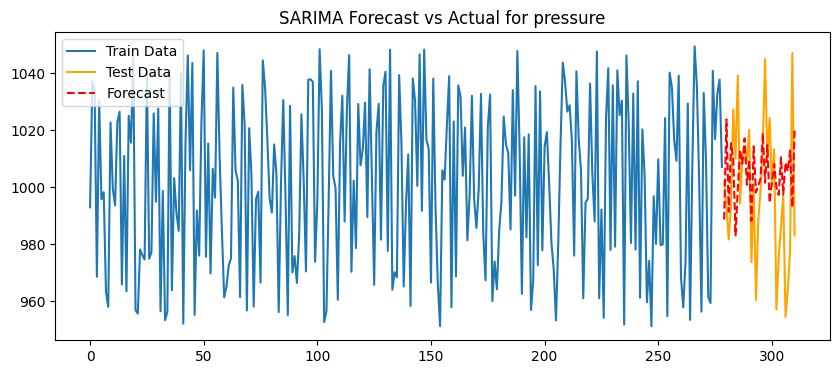

pressure - MAE: 21.438, RMSE: 26.716, MAPE: 2.15%

Final Model Errors:
 {'avg_temperature': {'MAE': 8.579499587371629, 'RMSE': 9.70377664922974, 'MAPE': 35.98763965257391}, 'humidity': {'MAE': 25.90885351517083, 'RMSE': 30.090345350893486, 'MAPE': 54.81097661076717}, 'avg_wind_speed': {'MAE': 3.8771978723953726, 'RMSE': 4.592553604208685, 'MAPE': 197.79628166028093}, 'cloud_cover': {'MAE': 22.664022022229943, 'RMSE': 27.05294874781146, 'MAPE': 165.98789278956033}, 'pressure': {'MAE': 21.438477818882358, 'RMSE': 26.71554948629668, 'MAPE': 2.154199223573906}}


In [37]:
warnings.filterwarnings("ignore")

columns = ["avg_temperature", "humidity", "avg_wind_speed", "cloud_cover", "pressure"]

order = (2, 1, 2)  # (p, d, q)
seasonal_order = (1, 1, 1, 30)  # (P, D, Q, s), s=30 for monthly seasonality

models = {}
errors = {}

# Train SARIMA model for each column with train-test split
for col in columns:
    print(f"Training SARIMA model for: {col}")

    train_size = int(len(model_2_df[col]) * 0.9)
    train, test = model_2_df[col][:train_size], model_2_df[col][train_size:]

    # Fit SARIMA model on training set
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_result = model.fit(disp=False)

    models[col] = sarima_result
    forecast = sarima_result.get_forecast(steps=len(test)).predicted_mean

    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = np.mean(np.abs((test - forecast) / test)) * 100  # Mean Absolute Percentage Error

    errors[col] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(train, label="Train Data")
    plt.plot(test, label="Test Data", color="orange")
    plt.plot(test.index, forecast, label="Forecast", linestyle="dashed", color="red")
    plt.title(f"SARIMA Forecast vs Actual for {col}")
    plt.legend()
    plt.show()

    print(f"{col} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%\n")
print("Final Model Errors:\n", errors)


Training SARIMA model for: avg_temperature


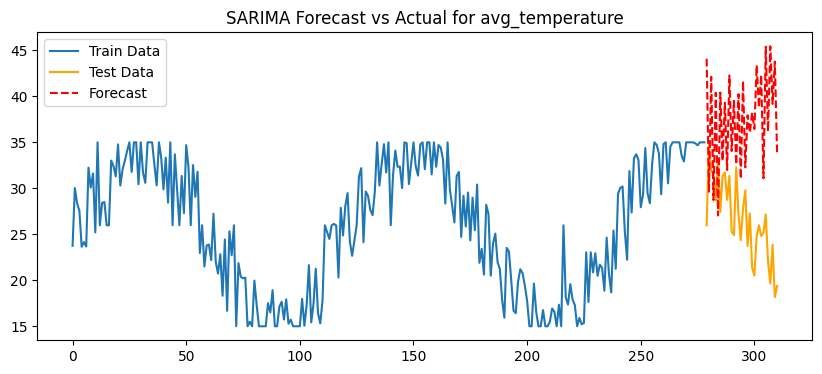

avg_temperature - MAE: 11.713, RMSE: 13.310, MAPE: 48.28%

Training SARIMA model for: humidity


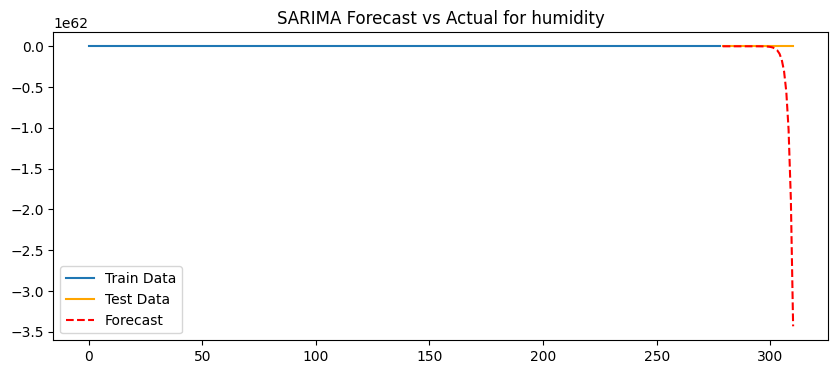

humidity - MAE: 23598032190316894762811488695117684253854466521299471111815168.000, RMSE: 72399180366444696464102199049483527148961274674412784504012800.000, MAPE: 63224187704972231053654279118107679837833397714598018171273216.00%

Training SARIMA model for: avg_wind_speed


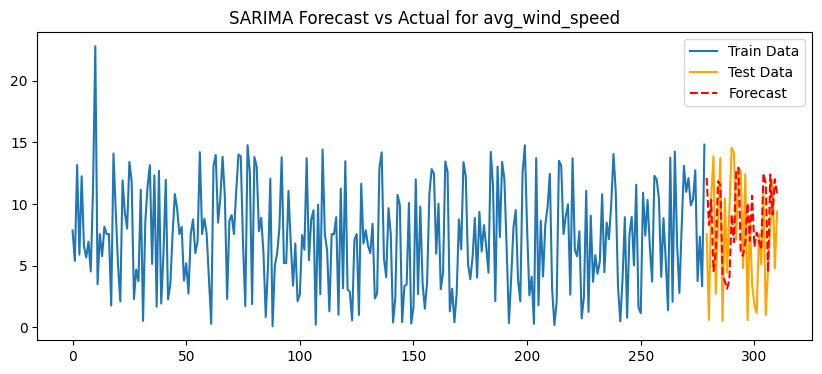

avg_wind_speed - MAE: 4.358, RMSE: 5.260, MAPE: 216.54%

Training SARIMA model for: cloud_cover


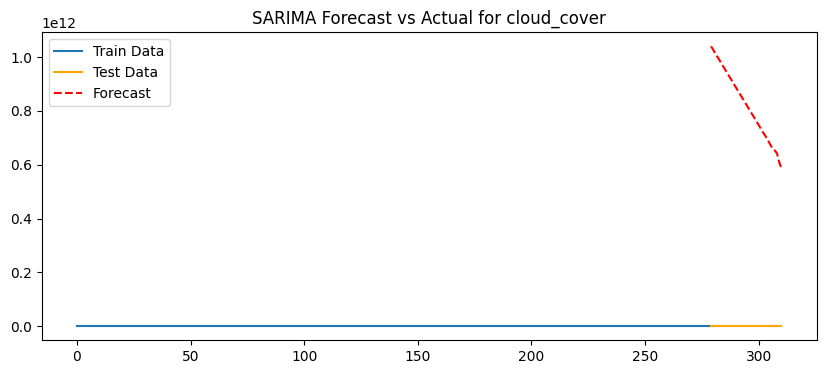

cloud_cover - MAE: 822818437394.810, RMSE: 833070444745.383, MAPE: 4053955384298.84%

Training SARIMA model for: pressure


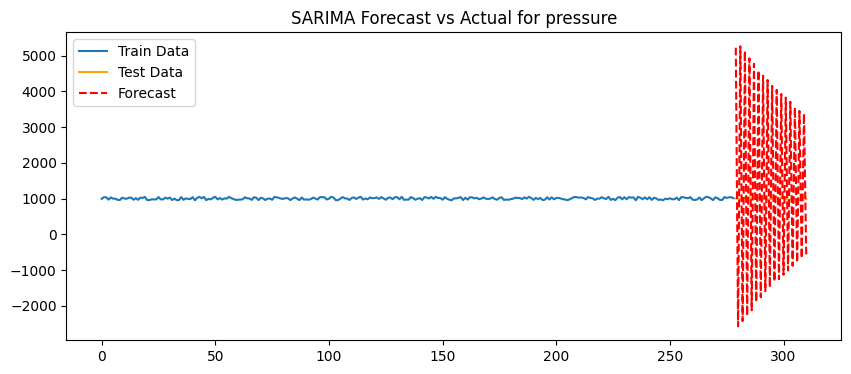

pressure - MAE: 2884.882, RMSE: 2978.555, MAPE: 288.41%

Final Model Errors:
 {'avg_temperature': {'MAE': 11.71265264592056, 'RMSE': 13.309558232666866, 'MAPE': 48.27864874099141}, 'humidity': {'MAE': 2.3598032190316895e+61, 'RMSE': 7.23991803664447e+61, 'MAPE': 6.322418770497223e+61}, 'avg_wind_speed': {'MAE': 4.358339301161034, 'RMSE': 5.260392649271156, 'MAPE': 216.5444902523732}, 'cloud_cover': {'MAE': 822818437394.8103, 'RMSE': 833070444745.3828, 'MAPE': 4053955384298.842}, 'pressure': {'MAE': 2884.881923559994, 'RMSE': 2978.555098002107, 'MAPE': 288.41393357141357}}


In [38]:
warnings.filterwarnings("ignore")

columns = ["avg_temperature", "humidity", "avg_wind_speed", "cloud_cover", "pressure"]

order = (2, 1, 2)  # (p, d, q)
seasonal_order = (1, 1, 1, 60)  # (P, D, Q, s)

models = {}
errors = {}

# Train SARIMA model for each column with train-test split
for col in columns:
    print(f"Training SARIMA model for: {col}")

    # Split data (90% train, 10% test)
    train_size = int(len(model_2_df[col]) * 0.9)
    train, test = model_2_df[col][:train_size], model_2_df[col][train_size:]

    # Fit SARIMA model on training set
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_result = model.fit(disp=False)

    models[col] = sarima_result
    forecast = sarima_result.get_forecast(steps=len(test)).predicted_mean

    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = np.mean(np.abs((test - forecast) / test)) * 100

    errors[col] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(train, label="Train Data")
    plt.plot(test, label="Test Data", color="orange")
    plt.plot(test.index, forecast, label="Forecast", linestyle="dashed", color="red")
    plt.title(f"SARIMA Forecast vs Actual for {col}")
    plt.legend()
    plt.show()

    print(f"{col} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%\n")
print("Final Model Errors:\n", errors)


Ctrl+ "/" to un-comment and run
commented due to excessive RAM usage and crashouts

In [ ]:
# warnings.filterwarnings("ignore")

# # Define columns for modeling
# columns = ["avg_temperature", "humidity", "avg_wind_speed", "cloud_cover", "pressure"]

# # Define SARIMA parameters
# order = (2, 1, 2)  # (p, d, q)
# seasonal_order = (1, 1, 1, 120)  # (P, D, Q, s)

# # Store models, forecasts, and errors
# models = {}
# errors = {}

# # Train SARIMA model for each column with train-test split
# for col in columns:
#     print(f"Training SARIMA model for: {col}")

#     # Split data (90% train, 10% test)
#     train_size = int(len(model_2_df[col]) * 0.9)
#     train, test = model_2_df[col][:train_size], model_2_df[col][train_size:]

#     # Fit SARIMA model on training set
#     model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
#     sarima_result = model.fit(disp=False)

#     models[col] = sarima_result
#     forecast = sarima_result.get_forecast(steps=len(test)).predicted_mean

#     mae = mean_absolute_error(test, forecast)
#     rmse = np.sqrt(mean_squared_error(test, forecast))
#     mape = np.mean(np.abs((test - forecast) / test)) * 100  # Mean Absolute Percentage Error

#     errors[col] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

#     # Plot results
#     plt.figure(figsize=(10, 4))
#     plt.plot(train, label="Train Data")
#     plt.plot(test, label="Test Data", color="orange")
#     plt.plot(test.index, forecast, label="Forecast", linestyle="dashed", color="red")
#     plt.title(f"SARIMA Forecast vs Actual for {col}")
#     plt.legend()
#     plt.show()

#     print(f"{col} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%\n")

# print("Final Model Errors:\n", errors)


#### Prophet Model

In [44]:
prophet_df= preprocessed_df.copy()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/120gr5ng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/uoc3pgoi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72168', 'data', 'file=/tmp/tmpuf21chp0/120gr5ng.json', 'init=/tmp/tmpuf21chp0/uoc3pgoi.json', 'output', 'file=/tmp/tmpuf21chp0/prophet_model09dyzm6v/prophet_model-20250309235312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:53:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


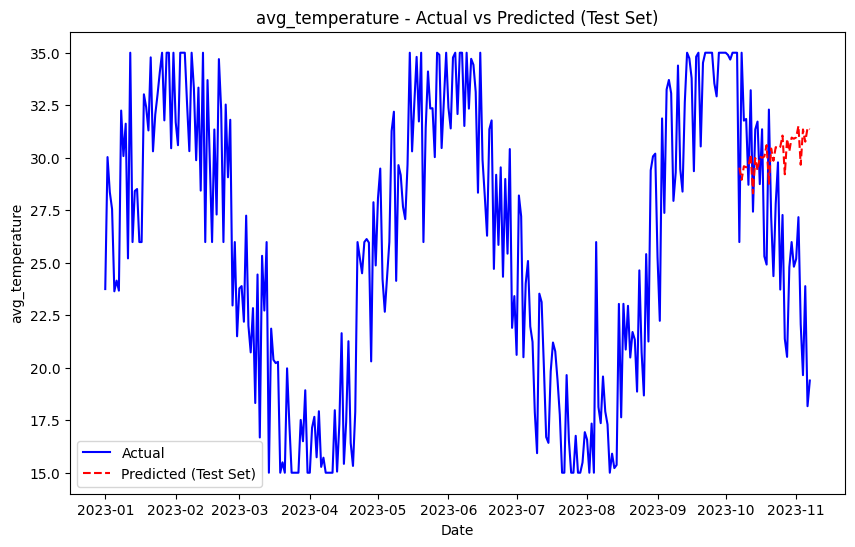

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/lldqteun.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/9trc9b8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89957', 'data', 'file=/tmp/tmpuf21chp0/lldqteun.json', 'init=/tmp/tmpuf21chp0/9trc9b8s.json', 'output', 'file=/tmp/tmpuf21chp0/prophet_modelvw2tl5ob/prophet_model-20250309235312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:53:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Metrics for avg_temperature:
MAE: 4.9445
RMSE: 5.9465
MAPE: 21.0034



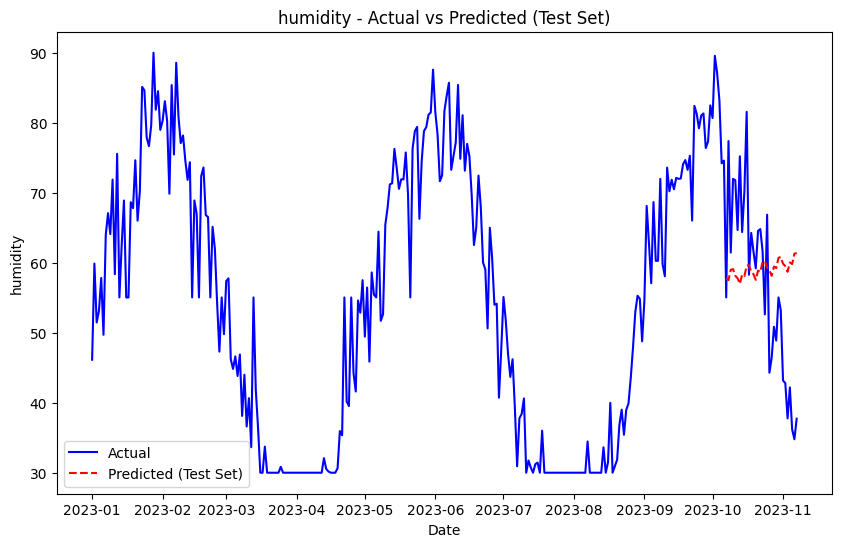

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/245_m10p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/smhvao_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77598', 'data', 'file=/tmp/tmpuf21chp0/245_m10p.json', 'init=/tmp/tmpuf21chp0/smhvao_4.json', 'output', 'file=/tmp/tmpuf21chp0/prophet_modelr99pbw5v/prophet_model-20250309235313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:53:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Metrics for humidity:
MAE: 11.3043
RMSE: 13.4617
MAPE: 22.6945



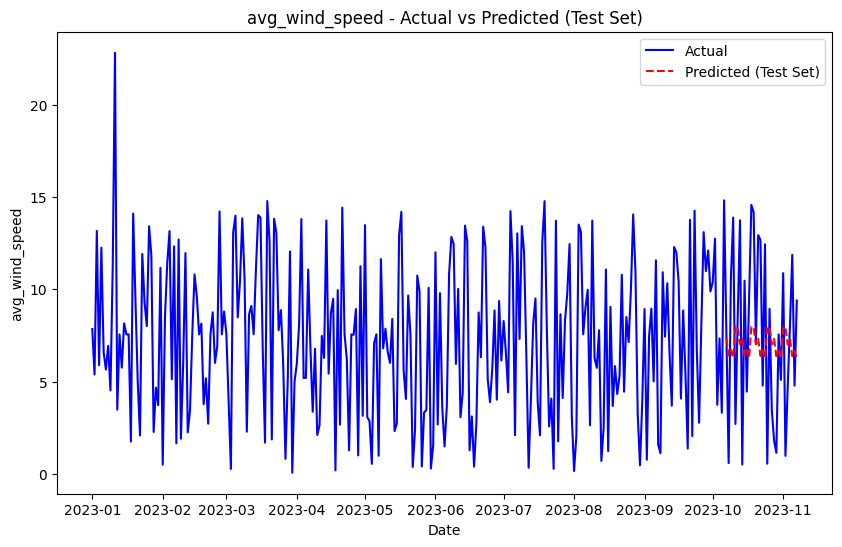

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/w08m95x4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/sxz0oq94.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88808', 'data', 'file=/tmp/tmpuf21chp0/w08m95x4.json', 'init=/tmp/tmpuf21chp0/sxz0oq94.json', 'output', 'file=/tmp/tmpuf21chp0/prophet_modelv2cddhnp/prophet_model-20250309235314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Metrics for avg_wind_speed:
MAE: 3.9823
RMSE: 4.6337
MAPE: 194.2689



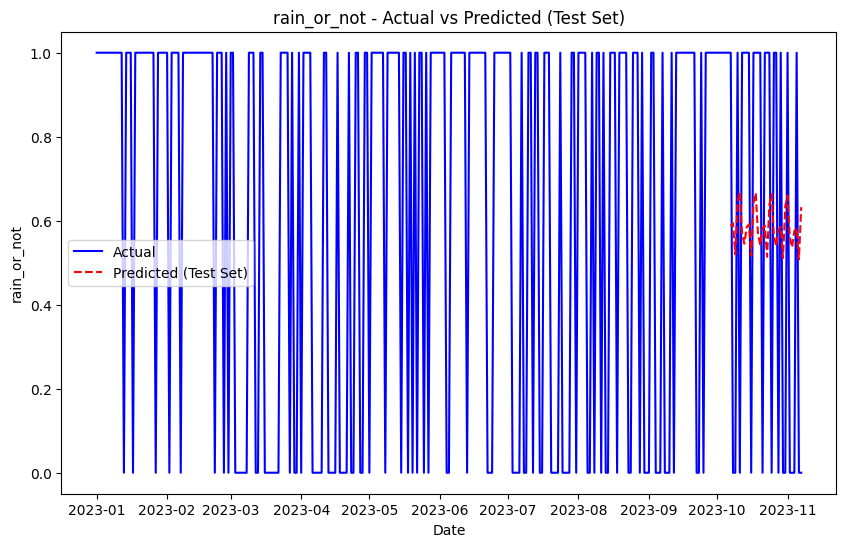

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/w1f61p2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/vyyonk0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20590', 'data', 'file=/tmp/tmpuf21chp0/w1f61p2x.json', 'init=/tmp/tmpuf21chp0/vyyonk0t.json', 'output', 'file=/tmp/tmpuf21chp0/prophet_model_qg3ds52/prophet_model-20250309235315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:53:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Metrics for rain_or_not:
MAE: 0.4835
RMSE: 0.4929
MAPE: inf



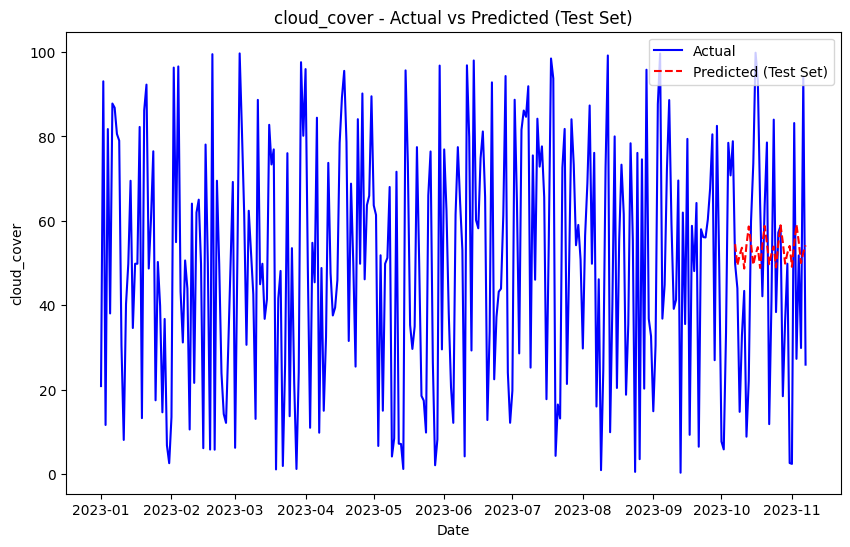

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/zjnonnu5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/pqgfxukg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46607', 'data', 'file=/tmp/tmpuf21chp0/zjnonnu5.json', 'init=/tmp/tmpuf21chp0/pqgfxukg.json', 'output', 'file=/tmp/tmpuf21chp0/prophet_modelhbtpdoue/prophet_model-20250309235316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:53:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:53:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Metrics for cloud_cover:
MAE: 22.6550
RMSE: 27.6244
MAPE: 193.0371



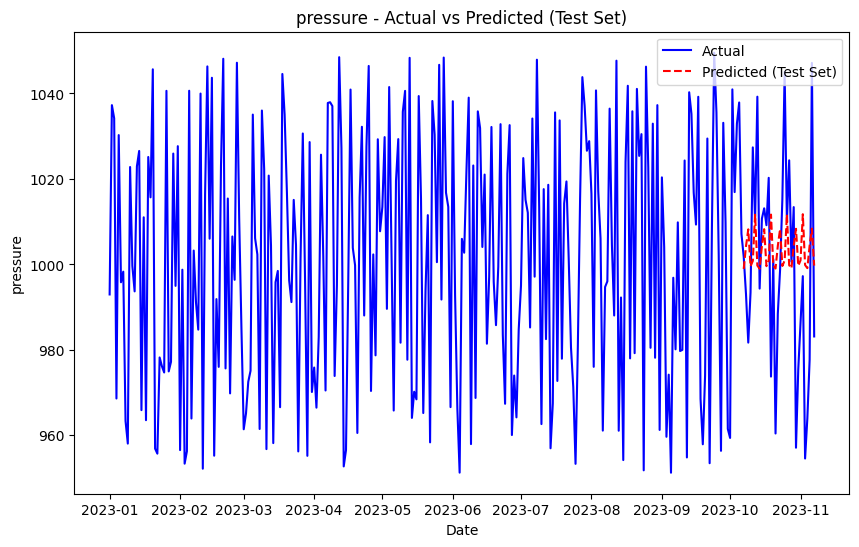

Metrics for pressure:
MAE: 19.5683
RMSE: 24.5401
MAPE: 1.9679



In [45]:
metrics_dict = {}

for column in prophet_df.columns[1:]:
    prophet_df_prophet = prophet_df[['date', column]].rename(columns={'date': 'ds', column: 'y'})

    # Split data into train and test sets (90/10 split)
    train_size = int(len(prophet_df_prophet) * 0.9)
    train_df = prophet_df_prophet[:train_size]
    test_df = prophet_df_prophet[train_size:]

    # Initialize and train the Prophet model
    model = Prophet()
    model.fit(train_df)

    future = model.make_future_dataframe(periods=len(test_df))
    forecast = model.predict(future)

    y_true = test_df['y'].values
    y_pred = forecast['yhat'][-len(test_df):].values

    # Calculate MAE, RMSE, and MAPE
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    metrics_dict[column] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    plt.figure(figsize=(10, 6))
    plt.plot(prophet_df_prophet['ds'], prophet_df_prophet['y'], label='Actual', color='blue')
    plt.plot(forecast['ds'][-len(test_df):], forecast['yhat'][-len(test_df):], label='Predicted (Test Set)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(f'{column} - Actual vs Predicted (Test Set)')
    plt.legend()
    plt.show()

    # Print out the metrics after the plot
    print(f"Metrics for {column}:")
    print(f"MAE: {metrics_dict[column]['MAE']:.4f}")
    print(f"RMSE: {metrics_dict[column]['RMSE']:.4f}")
    print(f"MAPE: {metrics_dict[column]['MAPE']:.4f}")
    print()


#### LSTM Model

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5371
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2028 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0470 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0546 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0369
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0340
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0315
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0280
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0280
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0295
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0282
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0266
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0265
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0282
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0260
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━

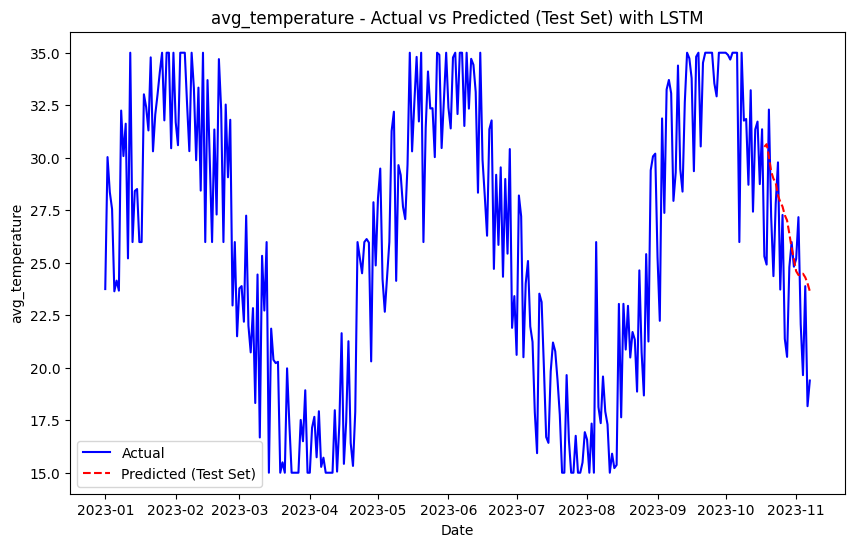

Metrics for avg_temperature:
MAE: 2.6864
RMSE: 3.3815
MAPE: 11.6223

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1802
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0460
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0303
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0186
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0149
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151 
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0138
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━

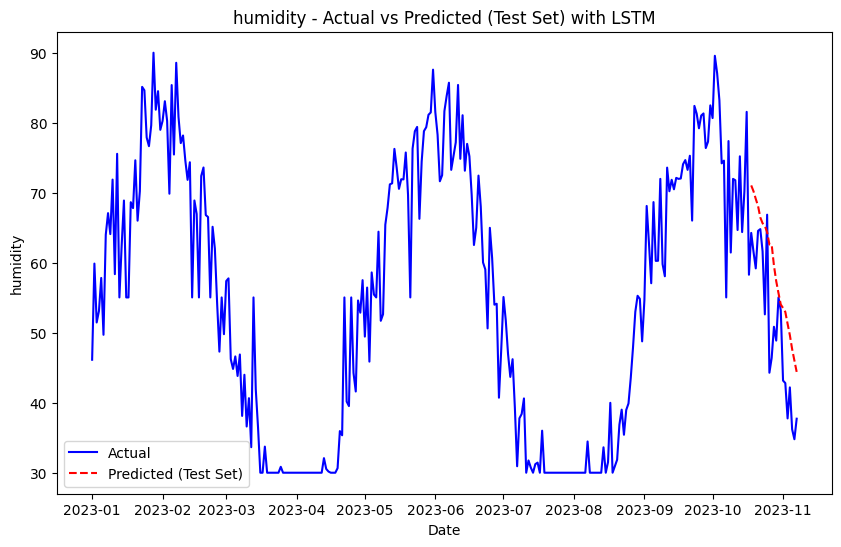

Metrics for humidity:
MAE: 7.5594
RMSE: 8.8232
MAPE: 16.0915

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0709
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0367
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0370
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0378 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0351
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0374
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0384
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0346
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0352
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0355
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0362
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0346
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0344
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0343
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 

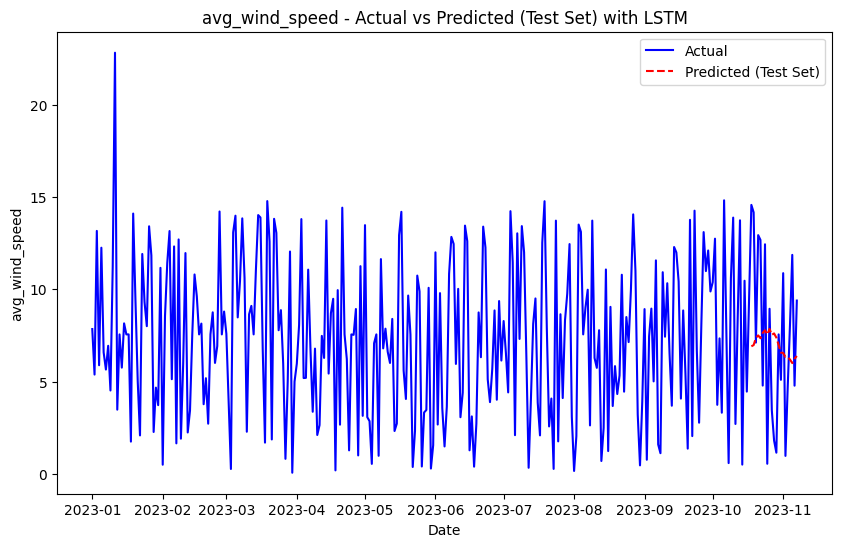

Metrics for avg_wind_speed:
MAE: 3.9647
RMSE: 4.5282
MAPE: 159.4580

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4157
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2488
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2269
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2134
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2258
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2269
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2274
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2282
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2291
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2199
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2252
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2277
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2228
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2231
Epoch 15/20
9/9 ━━━━━━━━━━━━━━

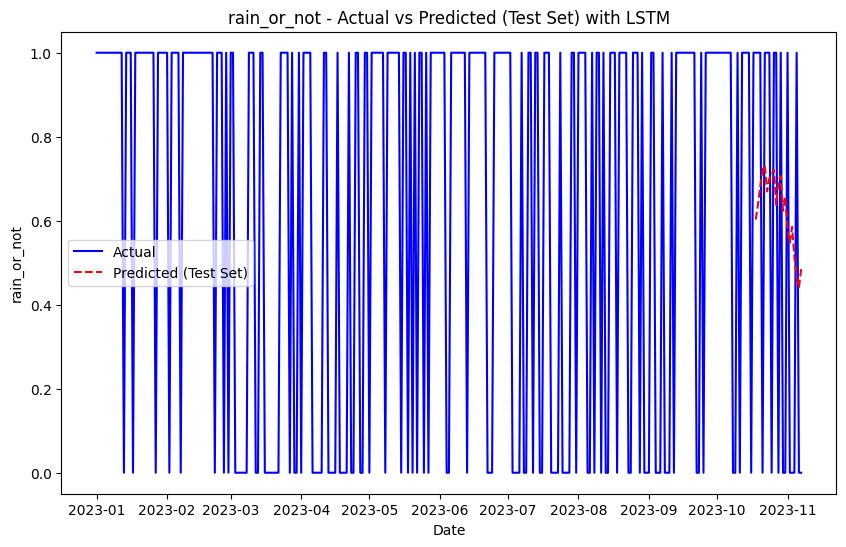

Metrics for rain_or_not:
MAE: 0.4652
RMSE: 0.4884
MAPE: inf

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1721
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0903 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0936 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0839
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0794
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0799
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0773
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0857
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0812
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0871
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0835
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0895
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0867
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0827
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


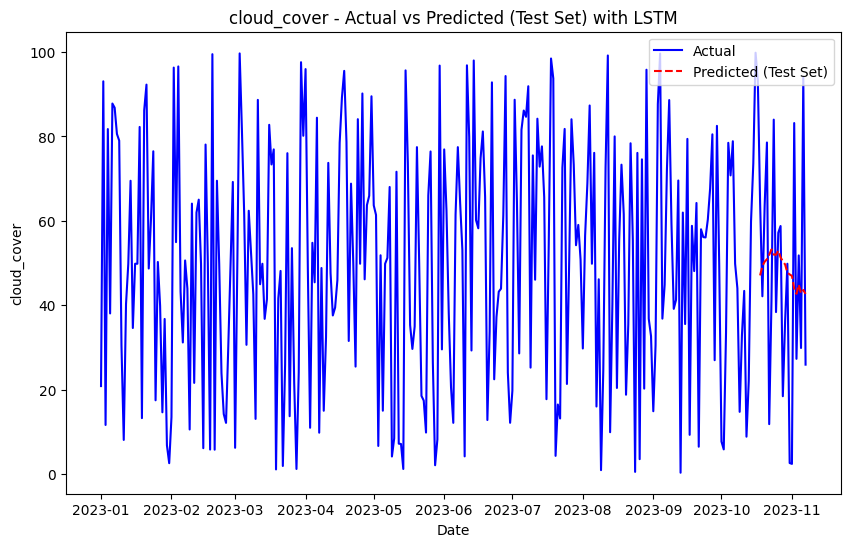

Metrics for cloud_cover:
MAE: 23.0988
RMSE: 27.7149
MAPE: 212.8338

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1921
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1012
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1069
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1036
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0976
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0958
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0933
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0921
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0987
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0968
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0938
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0987
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0954
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0860
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


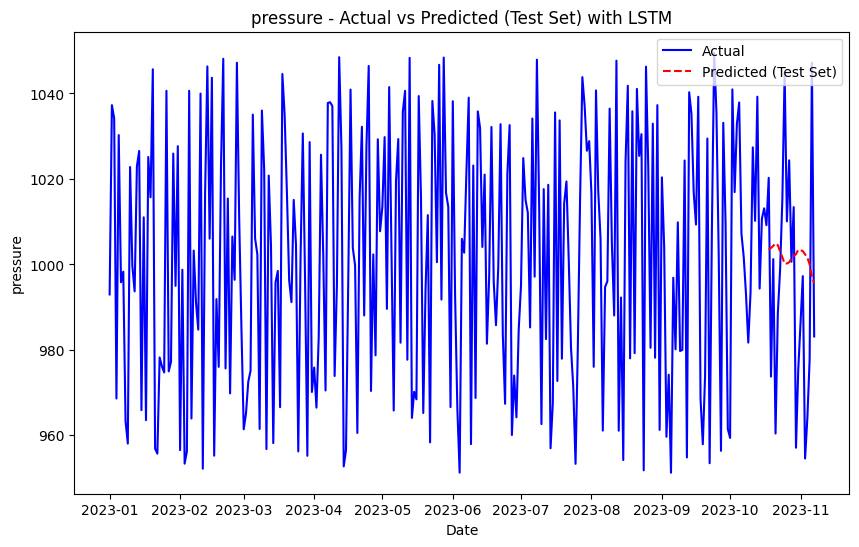

Metrics for pressure:
MAE: 22.5288
RMSE: 27.7538
MAPE: 2.2730



In [46]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

metrics_dict = {}

for column in prophet_df.columns[1:]:
    df = prophet_df[['date', column]].rename(columns={'date': 'ds', column: 'y'})
    data = df['y'].values.reshape(-1, 1)  # Convert to 2D array for LSTM

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    train_size = int(len(data) * 0.9)
    train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

    time_step = 10  # Number of previous time steps to predict the next value
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape X for LSTM (samples, time steps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(time_step, 1)))
    model.add(Dense(units=1))  # Output layer with 1 value (forecast)
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Make predictions
    y_pred_scaled = model.predict(X_test)

    # Inverse transform to get the actual predicted values
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate MAE, RMSE, and MAPE
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    metrics_dict[column] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    plt.figure(figsize=(10, 6))
    plt.plot(df['ds'], df['y'], label='Actual', color='blue')
    plt.plot(df['ds'][train_size + time_step + 1:], y_pred, label='Predicted (Test Set)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(f'{column} - Actual vs Predicted (Test Set) with LSTM')
    plt.legend()
    plt.show()

    print(f"Metrics for {column}:")
    print(f"MAE: {metrics_dict[column]['MAE']:.4f}")
    print(f"RMSE: {metrics_dict[column]['RMSE']:.4f}")
    print(f"MAPE: {metrics_dict[column]['MAPE']:.4f}")
    print()


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.4071
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1446 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0385
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0461 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0301
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0323 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0306
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0270
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0283
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0262
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0273
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0285 
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0283
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0284 
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0266
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━

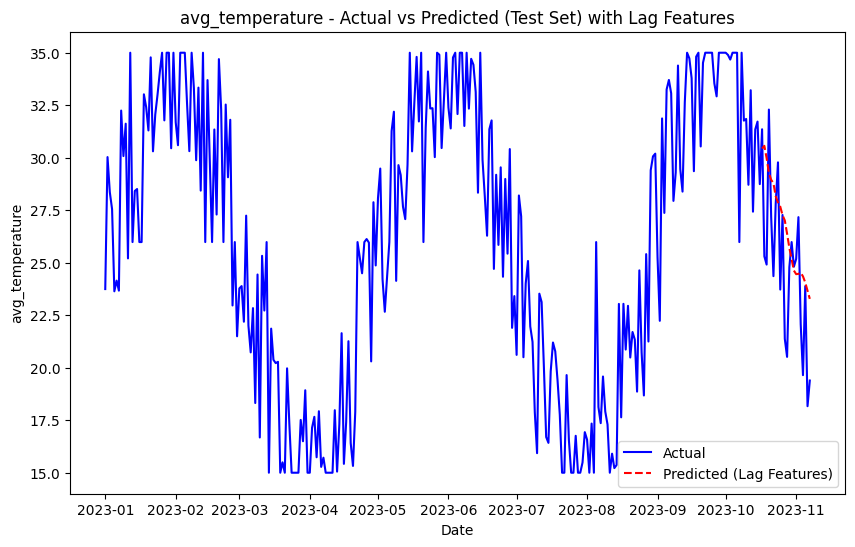

Metrics for avg_temperature:
MAE: 2.7386
RMSE: 3.4013
MAPE: 11.9967

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2865
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0826
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0278
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0228
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0198
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0161
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0159
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━

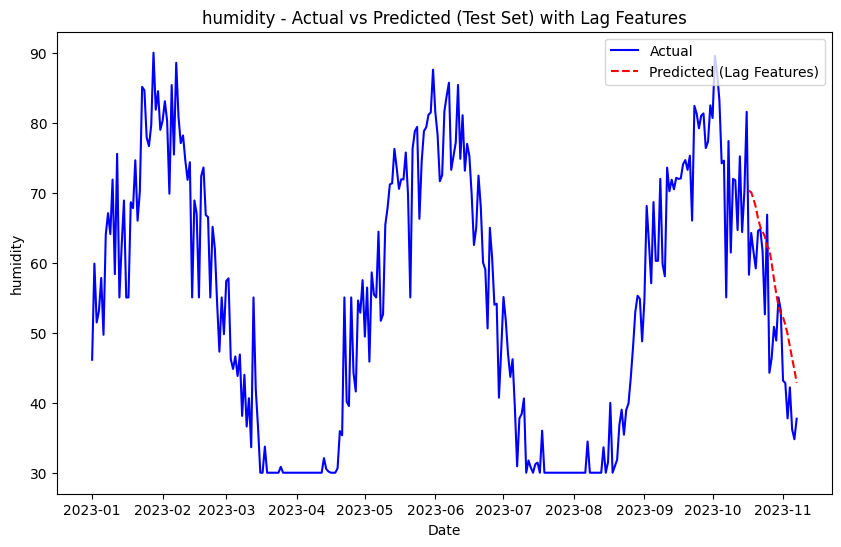

Metrics for humidity:
MAE: 7.3432
RMSE: 8.5566
MAPE: 15.8177

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1335
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0450
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0430
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0380 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0368
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0339
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0378
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0352
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0340
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0361
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0340
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0354
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0334 
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0337
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 

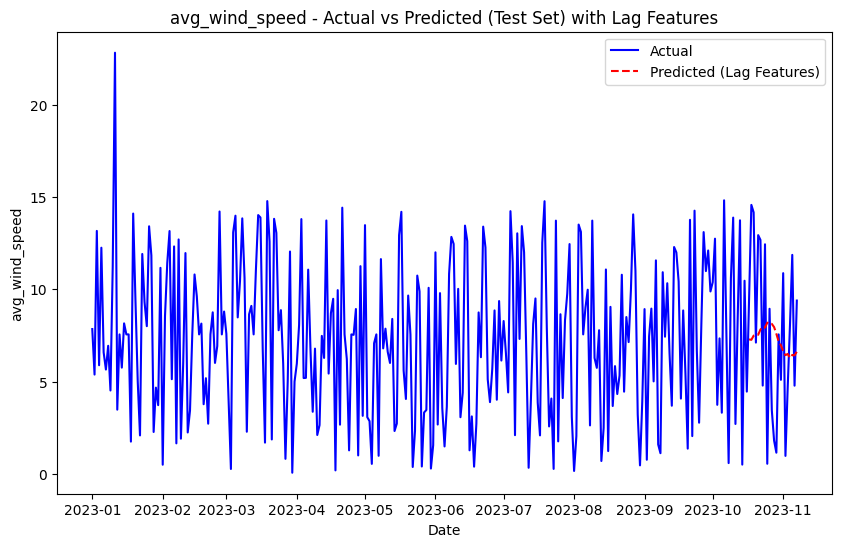

Metrics for avg_wind_speed:
MAE: 3.8899
RMSE: 4.4887
MAPE: 160.5870

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.5633
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3049
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2278
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2178
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2208 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2304
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2270
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2261
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2266
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2272
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2306
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2276
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2272
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2255
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━

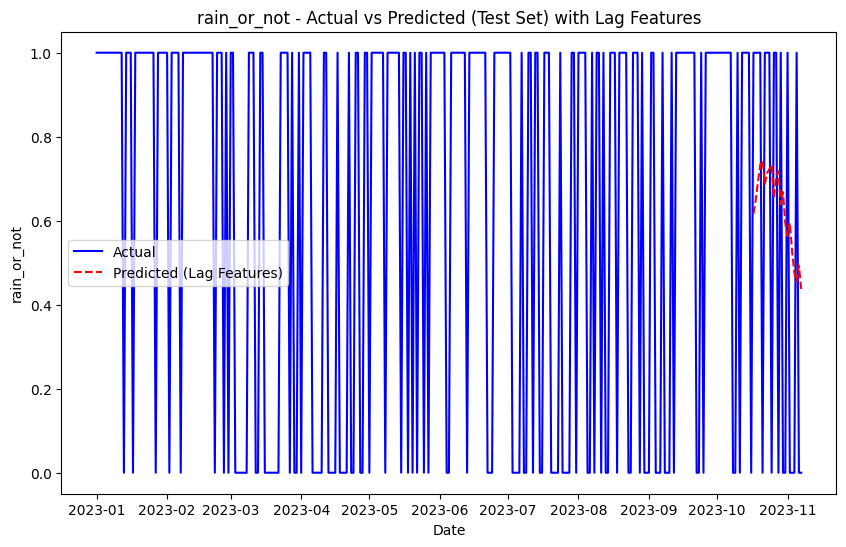

Metrics for rain_or_not:
MAE: 0.4613
RMSE: 0.4866
MAPE: inf

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2761
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1172
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0916
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0864
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0914
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0827
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0835
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0914
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0893
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0840
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0819
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0852
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0832
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0811
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

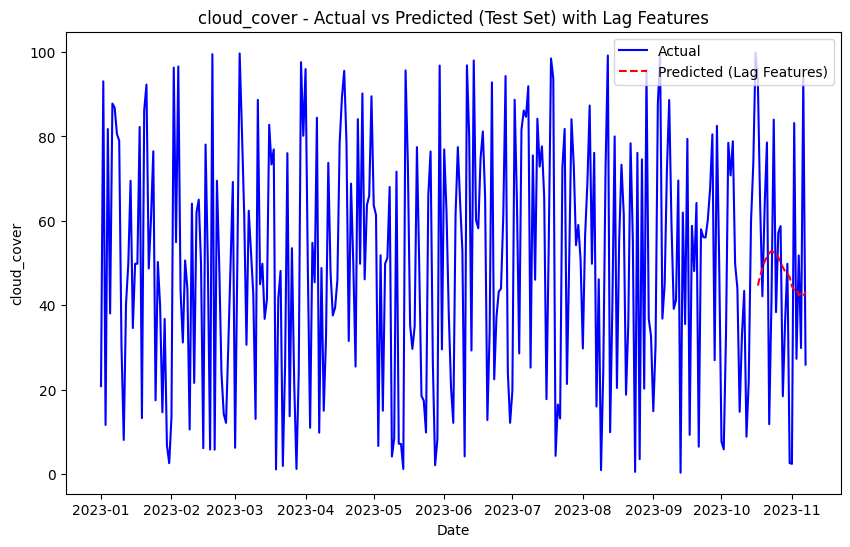

Metrics for cloud_cover:
MAE: 22.8943
RMSE: 27.4480
MAPE: 206.1635

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3141
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1205
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1080
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0996
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0991 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0907
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1032
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0954
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0966
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0938
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0958
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0961
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0974
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0950
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━

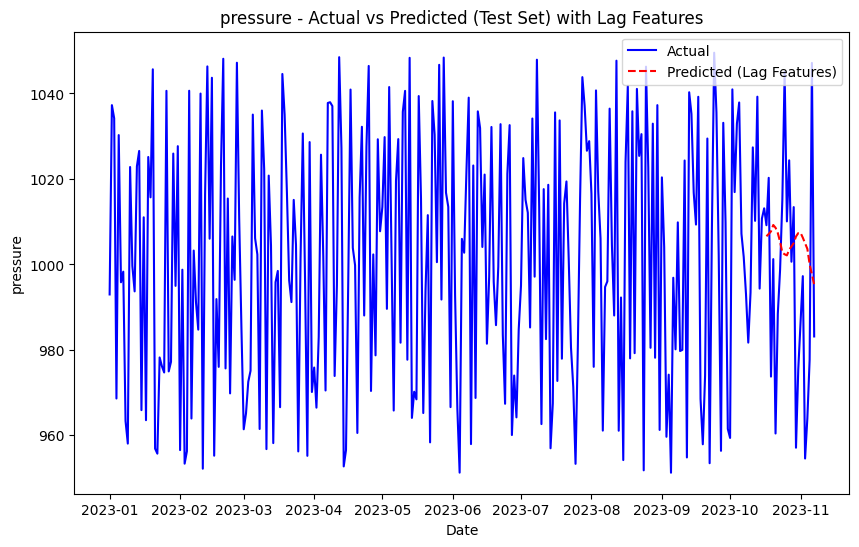

Metrics for pressure:
MAE: 23.3107
RMSE: 28.5044
MAPE: 2.3576



In [47]:
def create_lagged_features(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:(i + lag), 0])
        y.append(data[i + lag, 0])
    return np.array(X), np.array(y)

metrics_dict = {}

for column in prophet_df.columns[1:]:
    df = prophet_df[['date', column]].rename(columns={'date': 'ds', column: 'y'})
    data = df['y'].values.reshape(-1, 1)  # Convert to 2D array

    train_size = int(len(data) * 0.9)
    train_data, test_data = data[:train_size], data[train_size:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    lag = 10  # Number of lag features (previous time steps to use)
    X_train, y_train = create_lagged_features(train_data_scaled, lag)
    X_test, y_test = create_lagged_features(test_data_scaled, lag)

    # Reshape X for LSTM (samples, time steps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(lag, 1)))
    model.add(Dense(units=1))  # Output layer with 1 value (forecast)
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Make predictions
    y_pred_scaled = model.predict(X_test)

    # Inverse transform to get the actual predicted values
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate MAE, RMSE, and MAPE
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    metrics_dict[column] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    # Plotting the actual vs predicted values for the test set only
    plt.figure(figsize=(10, 6))
    plt.plot(df['ds'], df['y'], label='Actual', color='blue')
    plt.plot(df['ds'][train_size + lag:], y_pred, label='Predicted (Lag Features)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(f'{column} - Actual vs Predicted (Test Set) with Lag Features')
    plt.legend()
    plt.show()

    print(f"Metrics for {column}:")
    print(f"MAE: {metrics_dict[column]['MAE']:.4f}")
    print(f"RMSE: {metrics_dict[column]['RMSE']:.4f}")
    print(f"MAPE: {metrics_dict[column]['MAPE']:.4f}")
    print()


#### Stacking Model

In [ ]:
stack_df=preprocessed_df.copy()
stack_df


Predictions for avg_temperature for the next 7 days:
        date  predicted_value
0 2023-11-08        20.146713
1 2023-11-09        36.450303
2 2023-11-10       121.141587
3 2023-11-11        14.609558
4 2023-11-12       308.655849
5 2023-11-13       167.281674
6 2023-11-14        20.697539


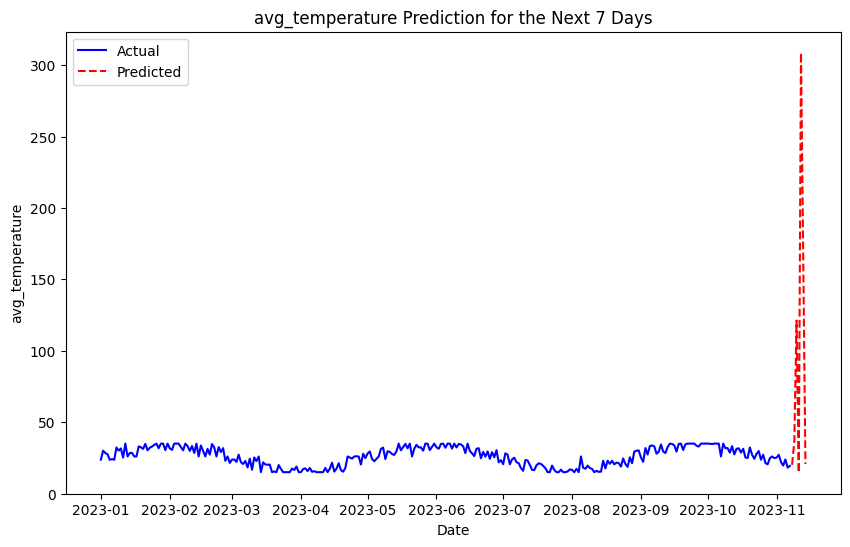

Metrics for avg_temperature - Training Data:
MAE: 2.1579
RMSE: 2.5574
MAPE: 8.9684

Predictions for humidity for the next 7 days:
        date  predicted_value
0 2023-11-08        35.751417
1 2023-11-09        24.992425
2 2023-11-10       998.160085
3 2023-11-11      -101.518669
4 2023-11-12      1170.790436
5 2023-11-13       743.004600
6 2023-11-14        54.364805


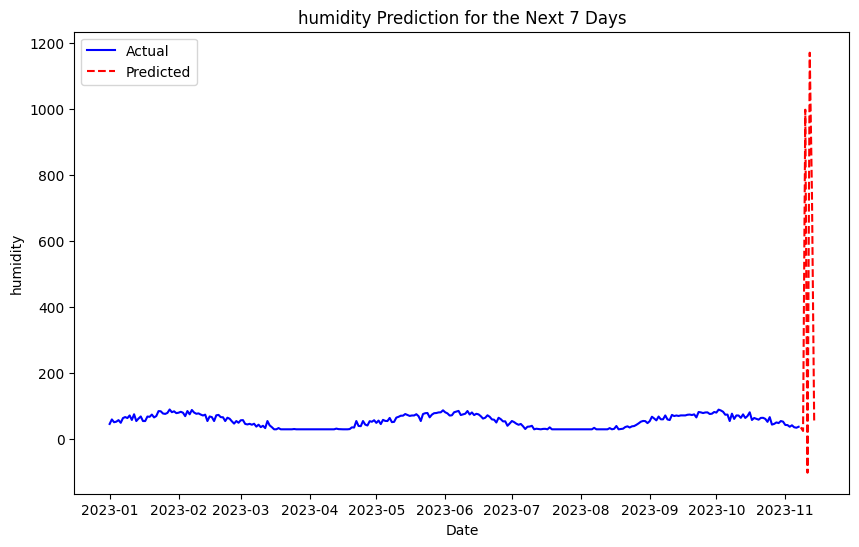

Metrics for humidity - Training Data:
MAE: 3.7039
RMSE: 4.7713
MAPE: 7.1706

Predictions for avg_wind_speed for the next 7 days:
        date  predicted_value
0 2023-11-08         7.407588
1 2023-11-09         8.516561
2 2023-11-10        21.628975
3 2023-11-11         1.703796
4 2023-11-12        10.169595
5 2023-11-13         8.620925
6 2023-11-14         7.457369


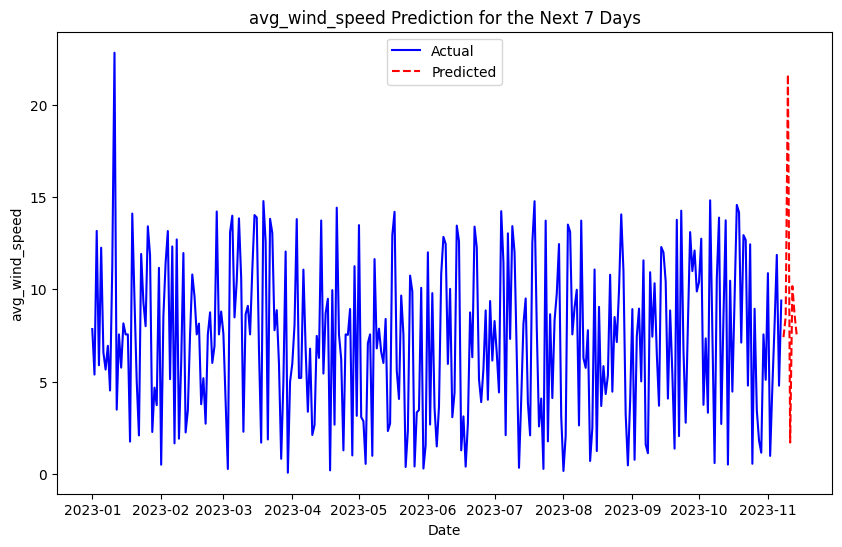

Metrics for avg_wind_speed - Training Data:
MAE: 3.4423
RMSE: 4.0810
MAPE: 204.6135

Predictions for cloud_cover for the next 7 days:
        date  predicted_value
0 2023-11-08        47.734563
1 2023-11-09        76.262306
2 2023-11-10        34.294620
3 2023-11-11        63.080832
4 2023-11-12       -29.159675
5 2023-11-13        96.414747
6 2023-11-14        74.580882


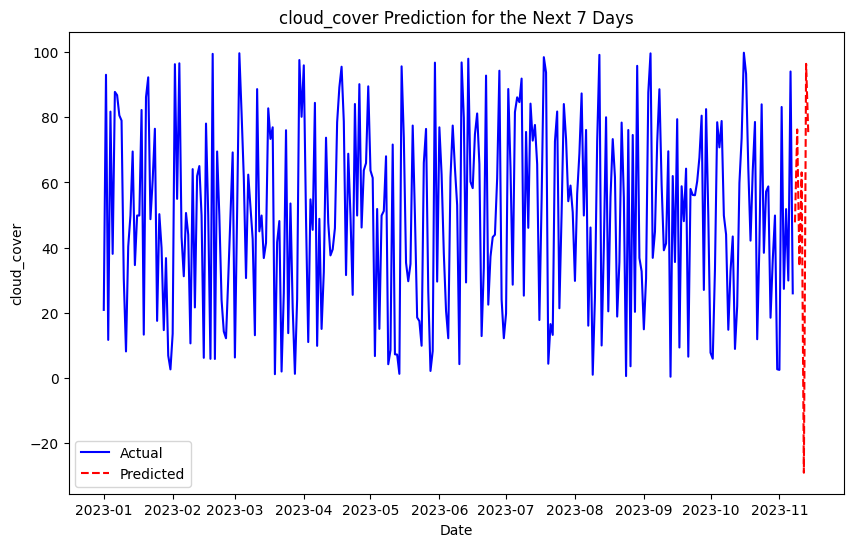

Metrics for cloud_cover - Training Data:
MAE: 21.5903
RMSE: 25.5305
MAPE: 246.7246

Predictions for pressure for the next 7 days:
        date  predicted_value
0 2023-11-08      1000.353914
1 2023-11-09      1010.977295
2 2023-11-10      1481.689866
3 2023-11-11      1495.855159
4 2023-11-12      1542.819016
5 2023-11-13      1710.137485
6 2023-11-14      1743.013704


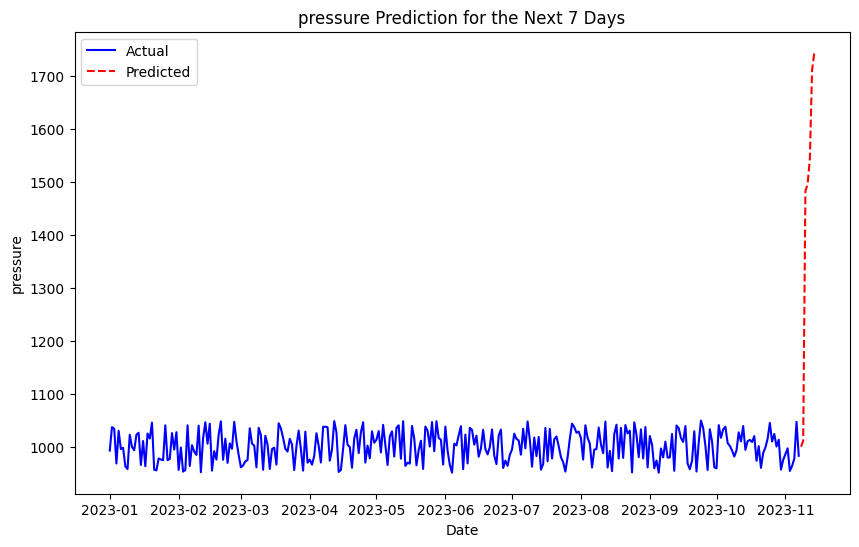

Metrics for pressure - Training Data:
MAE: 24.6451
RMSE: 28.5081
MAPE: 2.4678


In [49]:
# Function to create lag features
def create_lag_features(df, lag=3):
    df_lagged = df.copy()
    for i in range(1, lag + 1):
        for column in df.columns[1:]:  # Skip 'date' column and create lag features for all others
            df_lagged[f'{column}_lag_{i}'] = df_lagged[column].shift(i)
    df_lagged = df_lagged.dropna()  # Remove rows with NaN values due to shifting
    return df_lagged

columns_to_forecast = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

# Create lag features (lag of 3 for each feature)
df_lagged = create_lag_features(stack_df, lag=3)

# Define base estimators for the stacking regressor
estimators = [
    ('ridge', Ridge()),
    ('tree', DecisionTreeRegressor())
]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())

def forecast_next_days(model, X, last_date, n_days=7):
    future_predictions = []

    last_known_row = X.iloc[-1].to_numpy()  # Convert to NumPy array

    for i in range(n_days):
        # Predict for the next day
        prediction = model.predict(last_known_row.reshape(1, -1))
        future_predictions.append(prediction[0])

        last_known_row = np.roll(last_known_row, shift=-1)
        last_known_row[-1] = prediction

    # Generate future dates
    future_dates = pd.date_range(start=last_date, periods=n_days + 1, freq='D')[1:]

    return pd.DataFrame({'date': future_dates, 'predicted_value': future_predictions})

# Loop over the columns to forecast
for column in columns_to_forecast:
    # Features (X) and target (y)
    X = df_lagged.drop(columns=['date', column])
    y = df_lagged[column]

    stacking_model.fit(X, y)

    last_date = stack_df['date'].iloc[-1]

    future_predictions = forecast_next_days(stacking_model, X, last_date, n_days=7)

    print(f"\nPredictions for {column} for the next 7 days:")
    print(future_predictions)

    # Plot the predictions
    plt.figure(figsize=(10, 6))
    plt.plot(stack_df['date'], stack_df[column], label='Actual', color='blue')
    plt.plot(future_predictions['date'], future_predictions['predicted_value'], label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(f'{column} Prediction for the Next 7 Days')
    plt.legend()
    plt.show()

    # Evaluate the model (using MAE, RMSE, and MAPE)
    y_pred_train = stacking_model.predict(X)

    mae_train = mean_absolute_error(y, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y, y_pred_train))
    mape_train = np.mean(np.abs((y - y_pred_train) / y)) * 100

    print(f"Metrics for {column} - Training Data:")
    print(f"MAE: {mae_train:.4f}")
    print(f"RMSE: {rmse_train:.4f}")
    print(f"MAPE: {mape_train:.4f}")


## EDA

### Analyze data

In [50]:
# Load Dataset
df = pd.read_csv("weather_data.csv")
df['date'] = pd.to_datetime(df['date'])
df.head()

date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0 2023-01-01        23.745401  46.140905        7.845981        Rain   
1 2023-01-02        30.030503  59.876587        5.382457        Rain   
2 2023-01-03        28.365224  51.464618       13.158008        Rain   
3 2023-01-04        27.550929  53.103799        5.886677        Rain   
4 2023-01-05        23.639303  57.826186       12.248992        Rain   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331

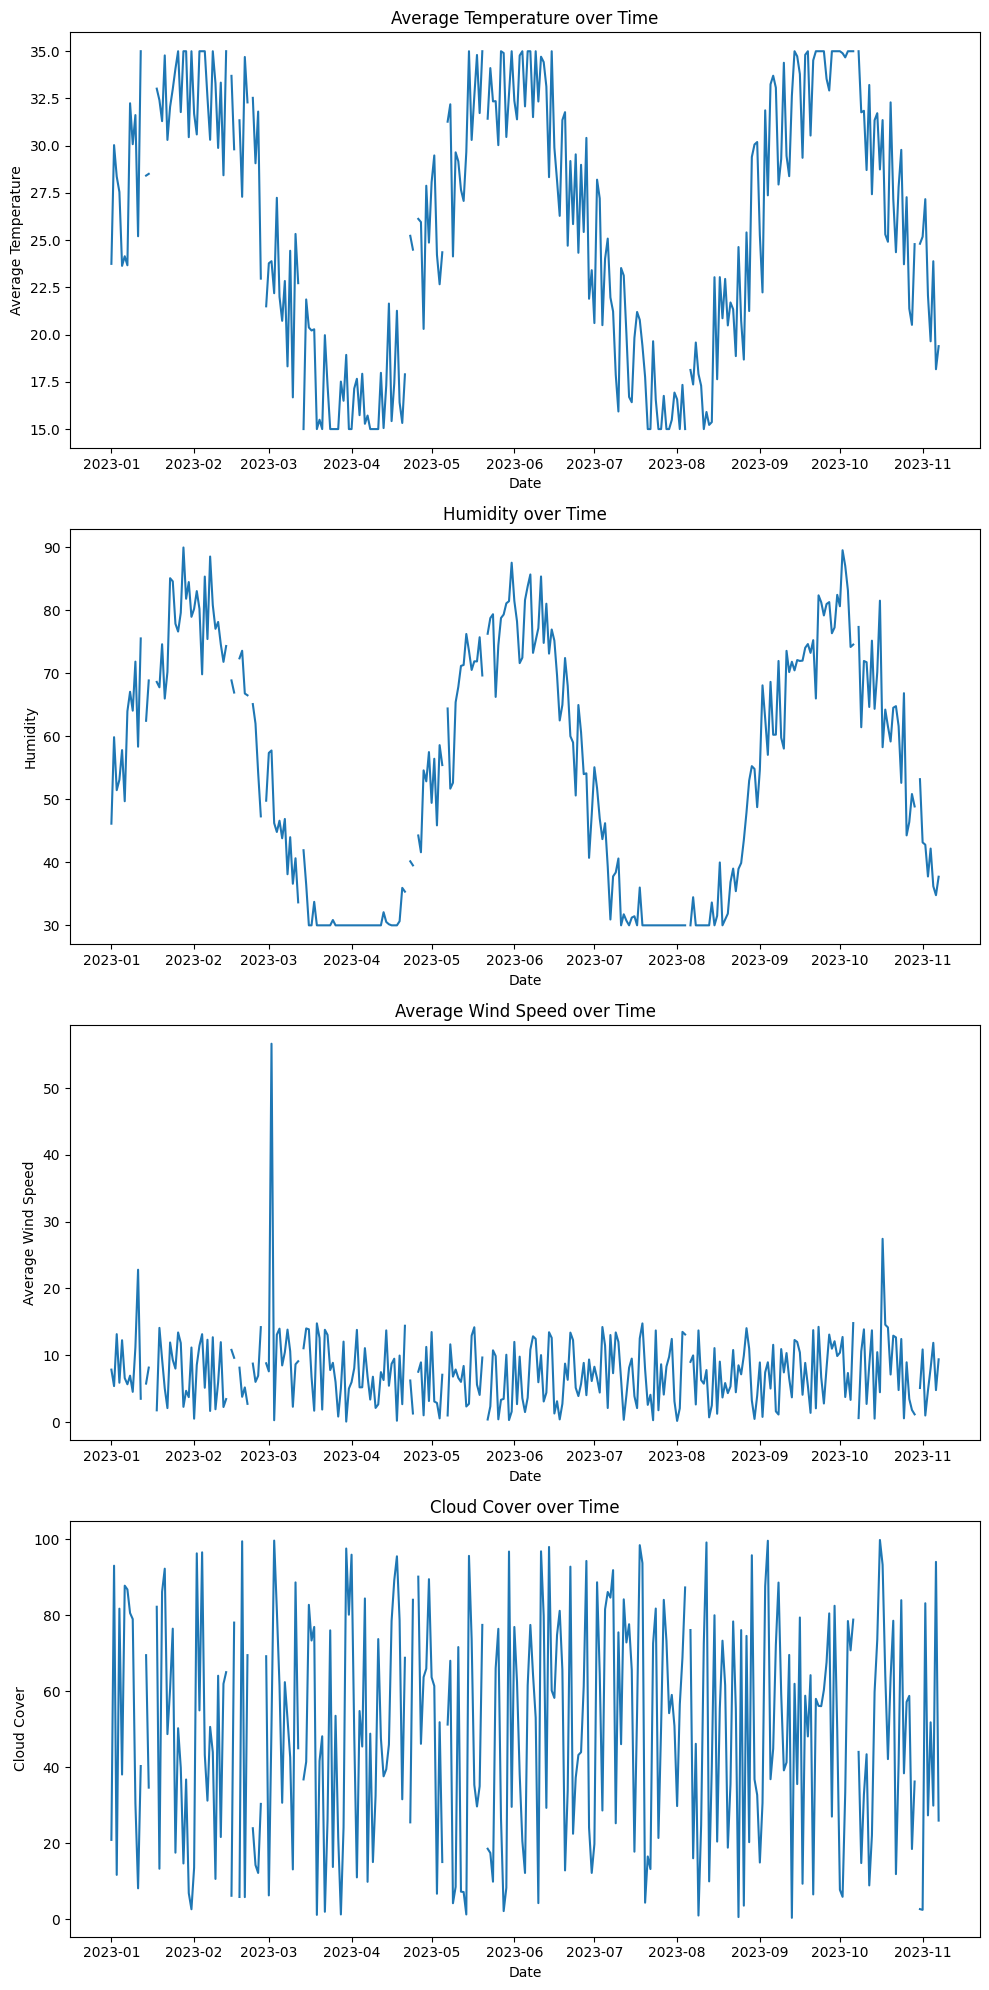

In [51]:
# Create separate plots for each of the five columns
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

# Plotting 'avg_temperature'
axes[0].plot(df['date'], df['avg_temperature'])
axes[0].set_title('Average Temperature over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Average Temperature')


# Plotting 'humidity'
axes[1].plot(df['date'], df['humidity'])
axes[1].set_title('Humidity over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Humidity')


# Plotting 'avg_wind_speed'
axes[2].plot(df['date'], df['avg_wind_speed'])
axes[2].set_title('Average Wind Speed over Time')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Average Wind Speed')


# Plotting 'cloud_cover'
axes[3].plot(df['date'], df['cloud_cover'])
axes[3].set_title('Cloud Cover over Time')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Cloud Cover')


# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [52]:
eda_df=preprocessed_df.copy()
eda_df

date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0   2023-01-01        23.745401  46.140905        7.845981            1   
1   2023-01-02        30.030503  59.876587        5.382457            1   
2   2023-01-03        28.365224  51.464618       13.158008            1   
3   2023-01-04        27.550929  53.103799        5.886677            1   
4   2023-01-05        23.639303  57.826186       12.248992            1   
..         ...              ...        ...             ...          ...   
306 2023-11-03        22.072834  37.756910        4.729355            0   
307 2023-11-04        19.645885  42.190604        8.092369            0   
308 2023-11-05        23.884496  36.205508       11.860847            1   
309 2023-11-06        18.168418  34.785000        4.781288            0   
310 2023-11-07        19.389714  37.717416        9.388371            0   

     cloud_cover     pressure  
0      20.851051   992.965681  
1      93.059521  1037.273025  
2      11.636640  1034.193357  
3      81.744971   968.610142  
4      38.062329  1030.264331  
..           ...          ...  
306    27.307081   954.564875  
307    51.807877   964.002410  
308    29.872557   977.681431  
309    94.067925  1047.153269  
310    25.929676   983.134701  

[311 rows x 7 columns]

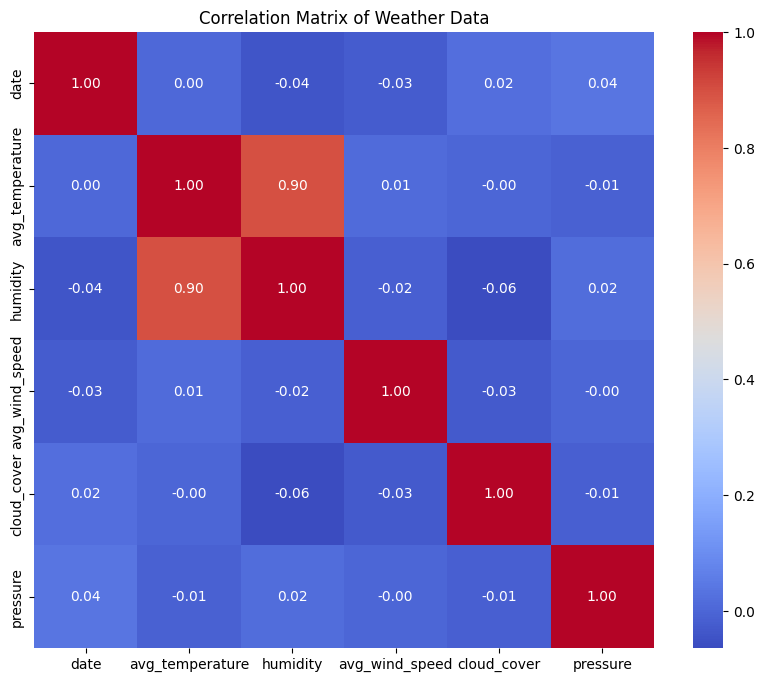

In [53]:
if 'rain_or_not' in eda_df.columns:
    eda_df = eda_df.drop('rain_or_not', axis=1)

# Generate the correlation matrix
correlation_matrix = eda_df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather Data')
plt.show()


### Outlier Detection
From the plots of the weather attributes, there are a few values that have deviated from the usual values.

#### 1. avg_temperature: 30 days

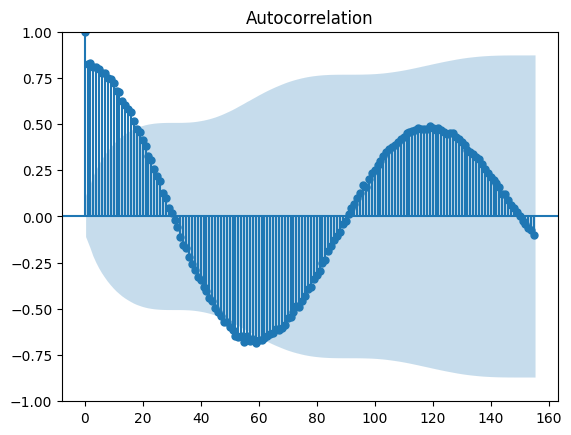

In [54]:
max_lags = len(df) // 2
plot_acf(eda_df['avg_temperature'].dropna(), lags=max_lags)  # Drop NaNs if necessary
plt.show()


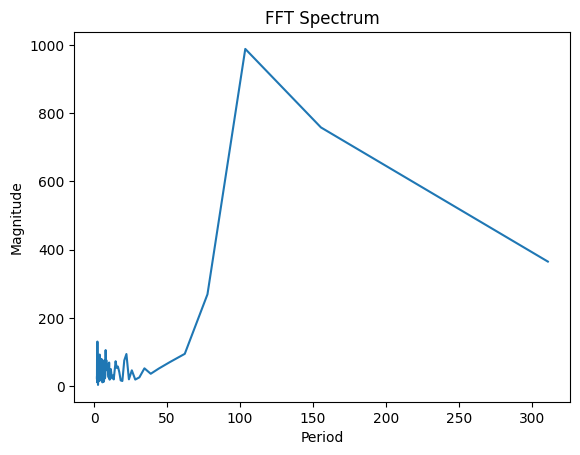

In [55]:
fft_vals = np.fft.fft(eda_df['avg_temperature'].dropna())
fft_freqs = np.fft.fftfreq(len(fft_vals))

plt.plot(1 / fft_freqs[1:len(fft_freqs)//2], np.abs(fft_vals[1:len(fft_freqs)//2]))
plt.xlabel('Period')
plt.ylabel('Magnitude')
plt.title('FFT Spectrum')
plt.show()

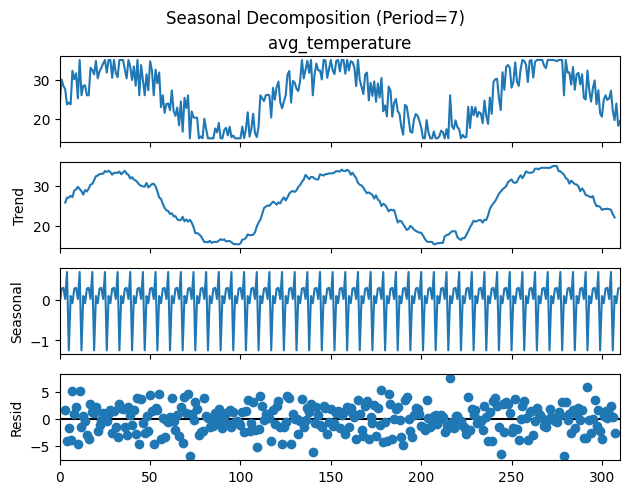

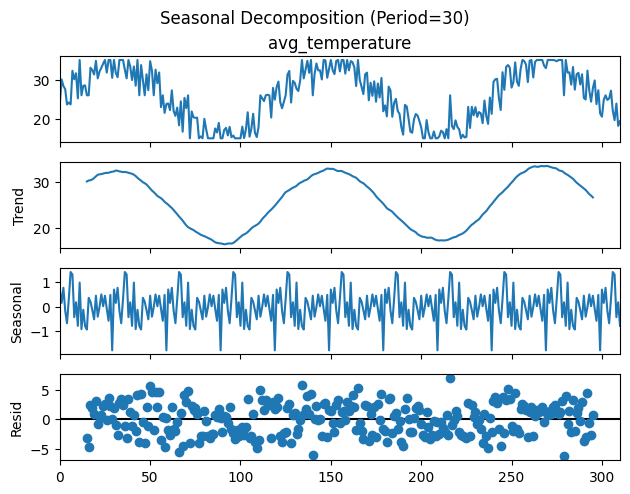

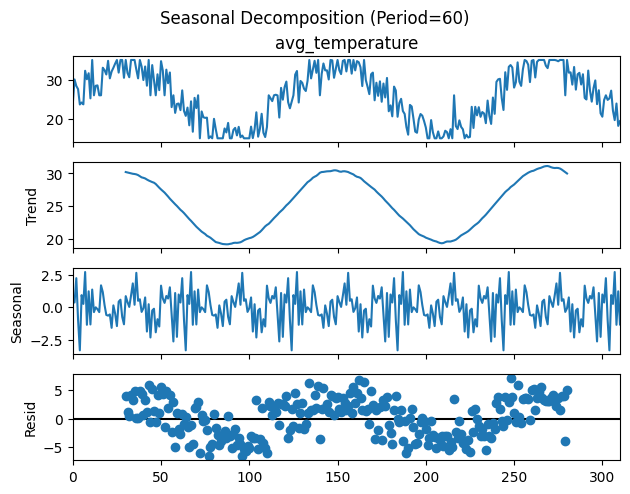

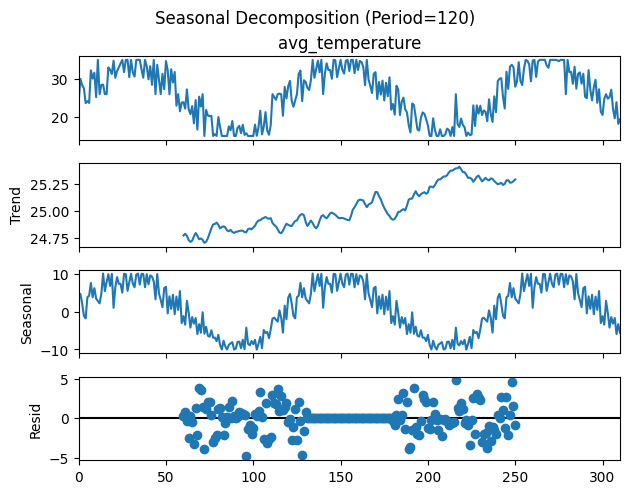

In [56]:
for p in [7, 30, 60, 120]:  # Weekly, Monthly, Bi-Monthly
    decomposition = seasonal_decompose(eda_df['avg_temperature'], model='additive', period=p)
    decomposition.plot()
    plt.suptitle(f"Seasonal Decomposition (Period={p})", y=1.02) #Added y parameter for vertical adjustment
    plt.show()


#### 2. humidity: 30 days


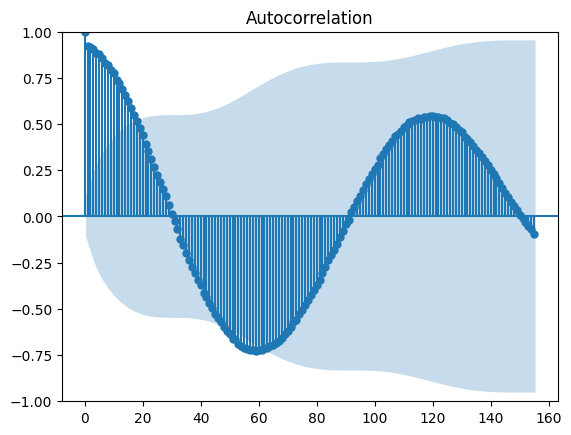

In [57]:
max_lags = len(df) // 2
plot_acf(eda_df['humidity'].dropna(), lags=max_lags)  # Drop NaNs if necessary
plt.show()

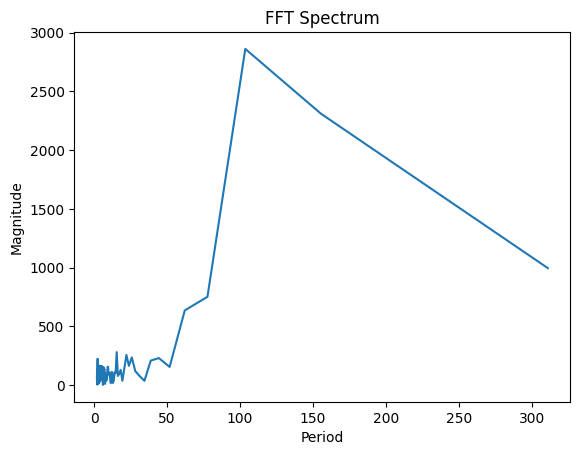

In [58]:
fft_vals = np.fft.fft(eda_df['humidity'].dropna())
fft_freqs = np.fft.fftfreq(len(fft_vals))

plt.plot(1 / fft_freqs[1:len(fft_freqs)//2], np.abs(fft_vals[1:len(fft_freqs)//2]))
plt.xlabel('Period')
plt.ylabel('Magnitude')
plt.title('FFT Spectrum')
plt.show()

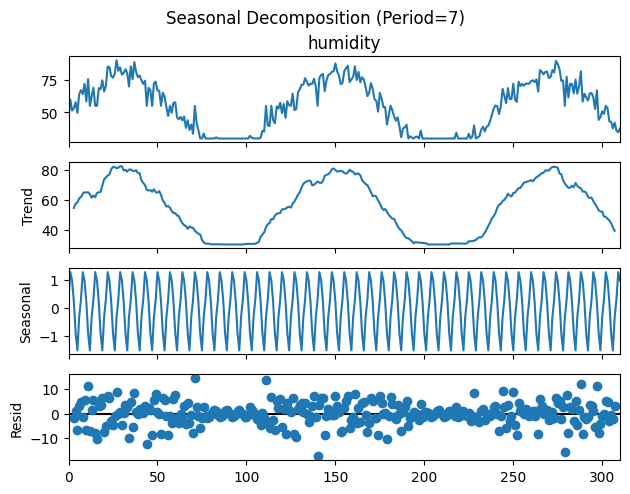

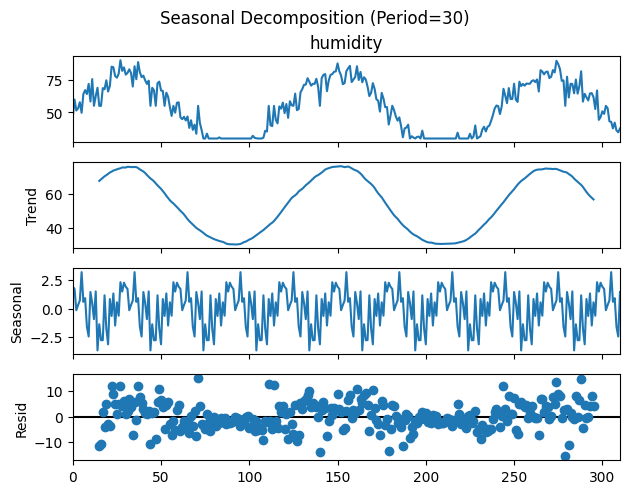

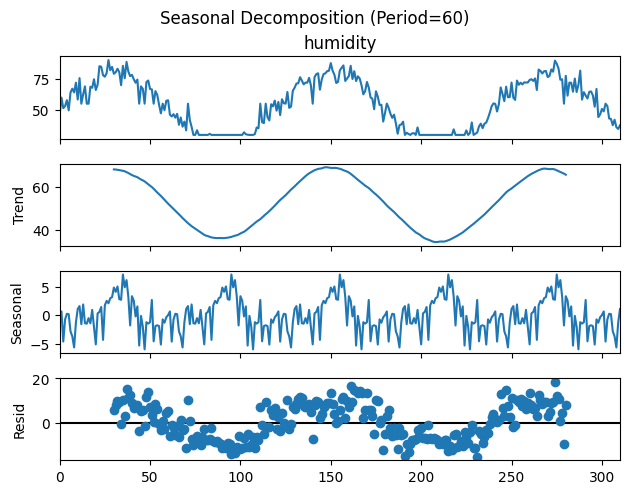

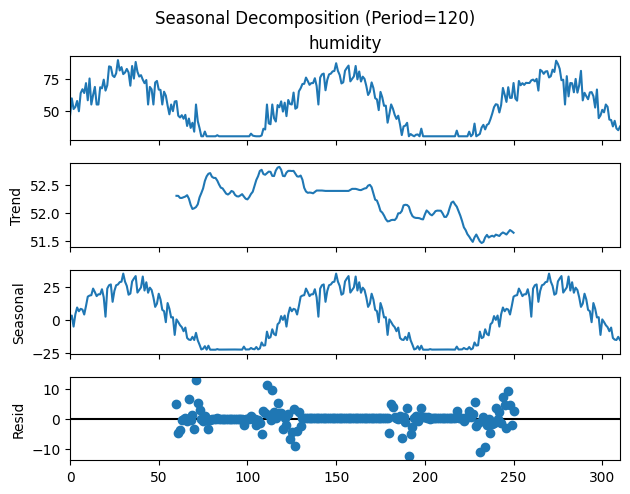

In [59]:
for p in [7, 30, 60, 120]:  # Weekly, Monthly, Bi-Monthly
    decomposition = seasonal_decompose(eda_df['humidity'], model='additive', period=p)
    decomposition.plot()
    plt.suptitle(f"Seasonal Decomposition (Period={p})", y=1.02) #Added y parameter for vertical adjustment
    plt.show()

#### 3.avg_wind_speed: 30 days

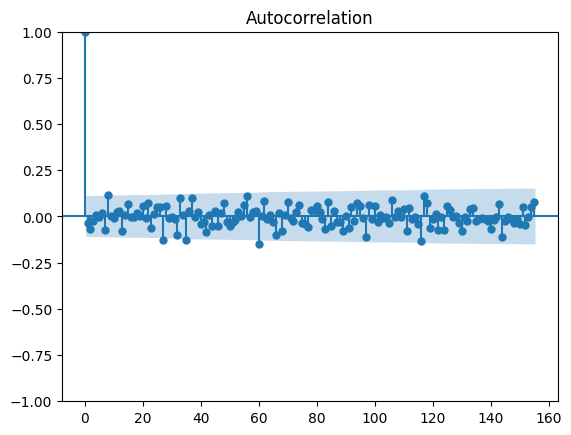

In [60]:
max_lags = len(df) // 2
plot_acf(eda_df['avg_wind_speed'].dropna(), lags=max_lags)  # Drop NaNs if necessary
plt.show()

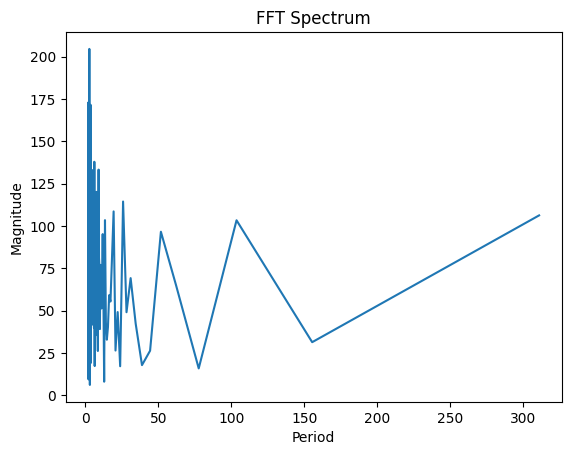

In [61]:
fft_vals = np.fft.fft(eda_df['avg_wind_speed'].dropna())
fft_freqs = np.fft.fftfreq(len(fft_vals))

plt.plot(1 / fft_freqs[1:len(fft_freqs)//2], np.abs(fft_vals[1:len(fft_freqs)//2]))
plt.xlabel('Period')
plt.ylabel('Magnitude')
plt.title('FFT Spectrum')
plt.show()

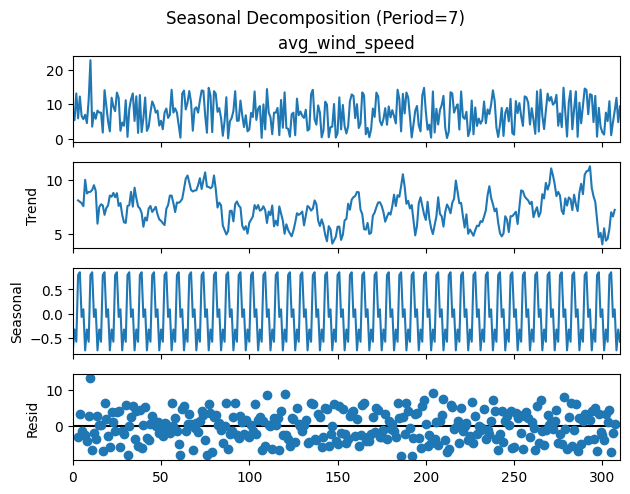

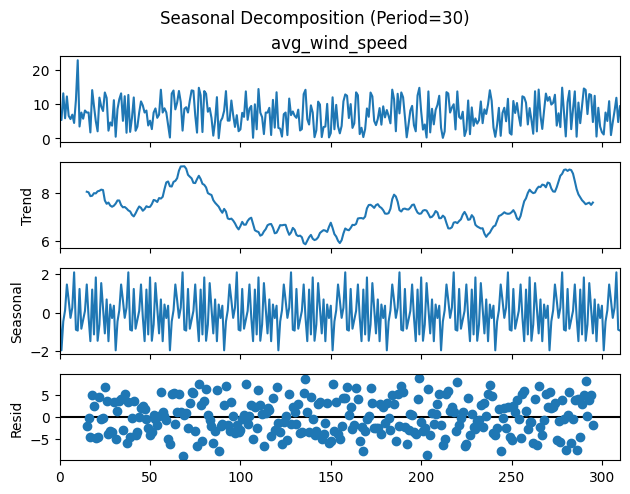

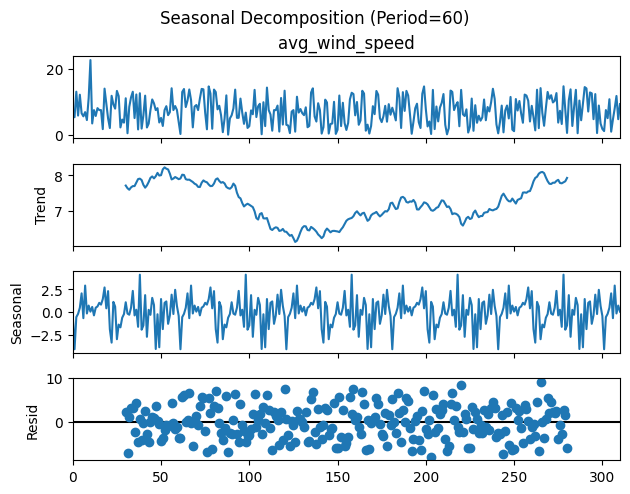

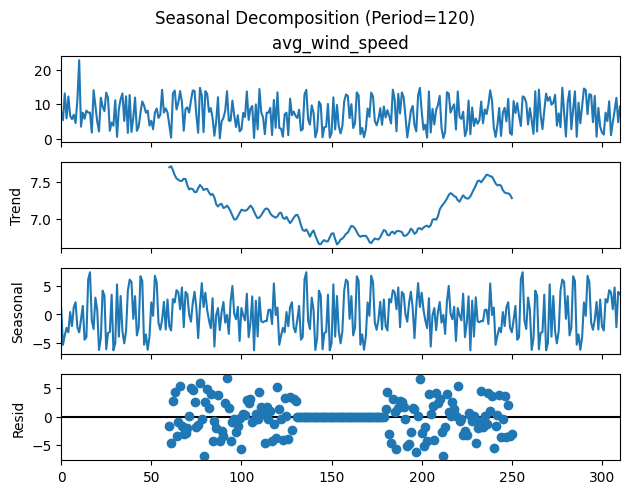

In [62]:
for p in [7, 30, 60, 120]:  # Weekly, Monthly, Bi-Monthly
    decomposition = seasonal_decompose(eda_df['avg_wind_speed'], model='additive', period=p)
    decomposition.plot()
    plt.suptitle(f"Seasonal Decomposition (Period={p})", y=1.02) #Added y parameter for vertical adjustment
    plt.show()

#### 4. cloud_cover: 7 days

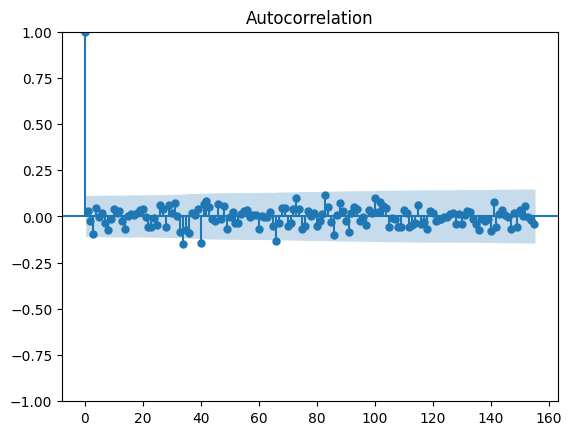

In [63]:
max_lags = len(df) // 2
plot_acf(eda_df['cloud_cover'].dropna(), lags=max_lags)  # Drop NaNs if necessary
plt.show()

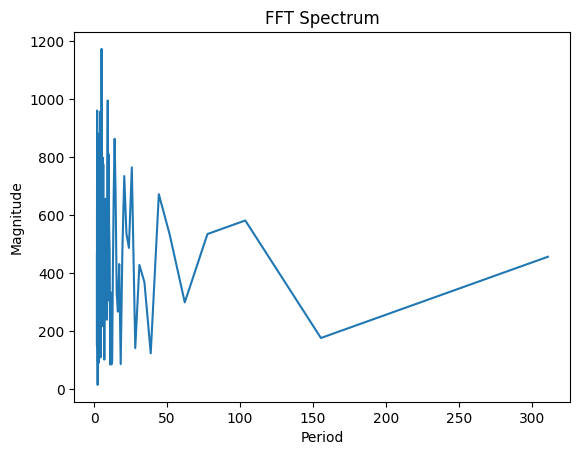

In [64]:
fft_vals = np.fft.fft(eda_df['cloud_cover'].dropna())
fft_freqs = np.fft.fftfreq(len(fft_vals))

plt.plot(1 / fft_freqs[1:len(fft_freqs)//2], np.abs(fft_vals[1:len(fft_freqs)//2]))
plt.xlabel('Period')
plt.ylabel('Magnitude')
plt.title('FFT Spectrum')
plt.show()

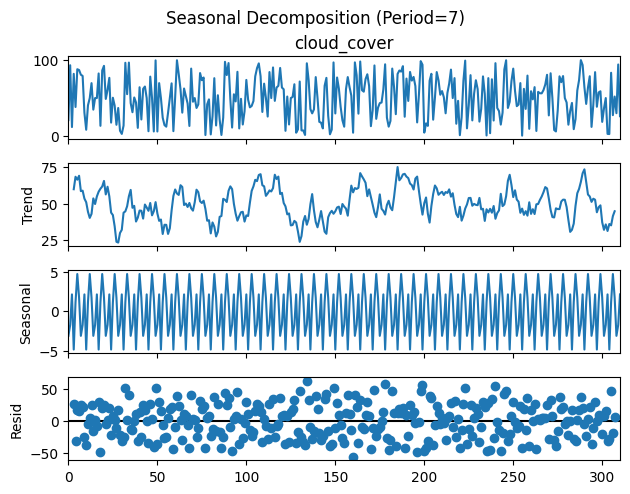

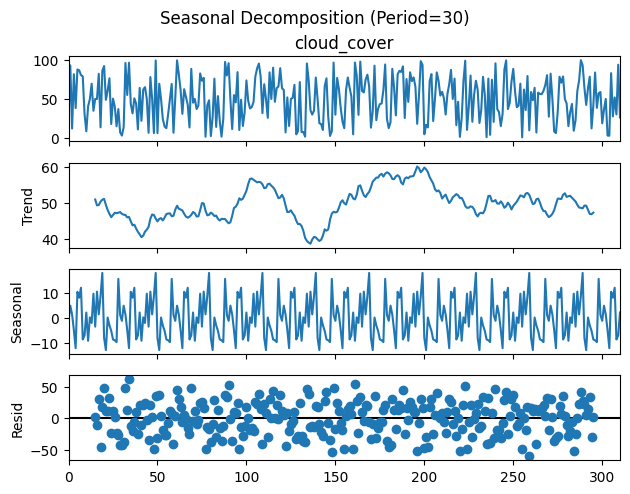

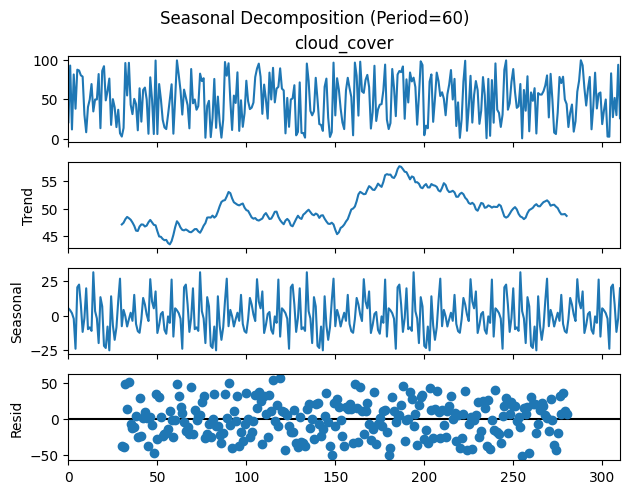

In [65]:
for p in [7, 30, 60]:  # Weekly, Monthly, Bi-Monthly
    decomposition = seasonal_decompose(eda_df['cloud_cover'], model='additive', period=p)
    decomposition.plot()
    plt.suptitle(f"Seasonal Decomposition (Period={p})", y=1.02) #Added y parameter for vertical adjustment
    plt.show()

#### 5. pressure

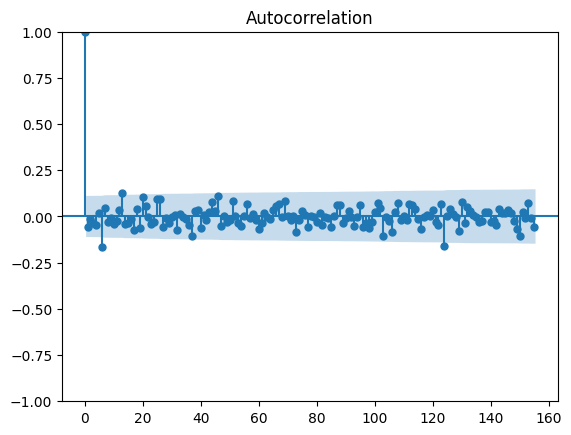

In [66]:
max_lags = len(df) // 2
plot_acf(eda_df['pressure'].dropna(), lags=max_lags)  # Drop NaNs if necessary
plt.show()

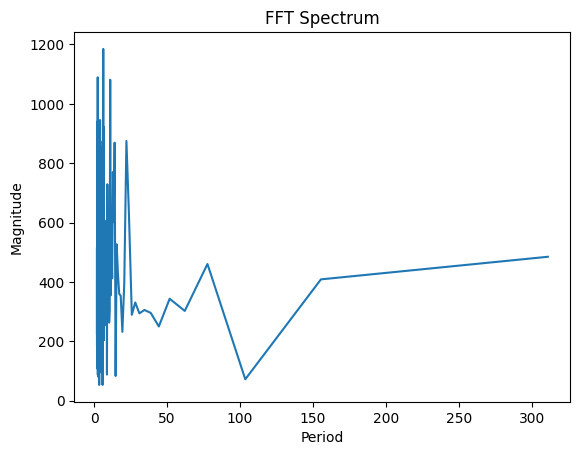

In [67]:
fft_vals = np.fft.fft(eda_df['pressure'].dropna())
fft_freqs = np.fft.fftfreq(len(fft_vals))

plt.plot(1 / fft_freqs[1:len(fft_freqs)//2], np.abs(fft_vals[1:len(fft_freqs)//2]))
plt.xlabel('Period')
plt.ylabel('Magnitude')
plt.title('FFT Spectrum')
plt.show()

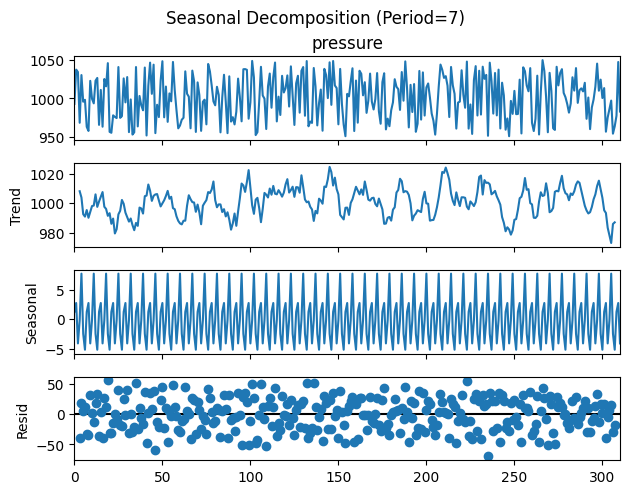

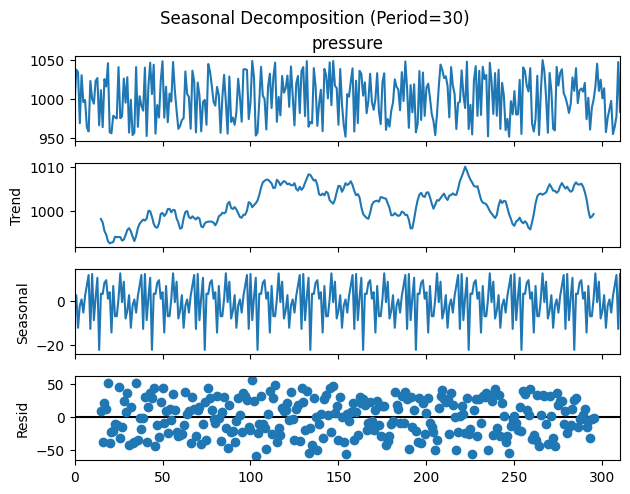

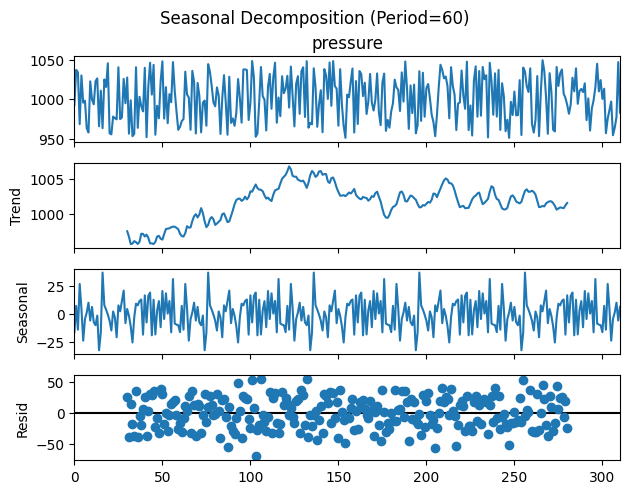

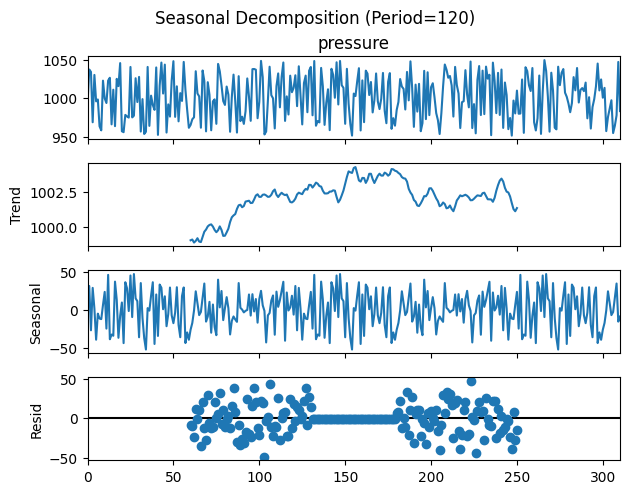

In [68]:
for p in [7, 30, 60, 120]:  # Weekly, Monthly, Bi-Monthly
    decomposition = seasonal_decompose(eda_df['pressure'], model='additive', period=p)
    decomposition.plot()
    plt.suptitle(f"Seasonal Decomposition (Period={p})", y=1.02) #Added y parameter for vertical adjustment
    plt.show()

# **Forecast**

In [69]:
preprocessed_df = pd.read_csv("preprocessed_weather_data.csv")
print(preprocessed_df.head())

         date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0  2023-01-01        23.745401  46.140905        7.845981            1   
1  2023-01-02        30.030503  59.876587        5.382457            1   
2  2023-01-03        28.365224  51.464618       13.158008            1   
3  2023-01-04        27.550929  53.103799        5.886677            1   
4  2023-01-05        23.639303  57.826186       12.248992            1   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331  


In [ ]:

temperature_data = preprocessed_df['avg_temperature'].values
wind_speed_data = preprocessed_df['avg_wind_speed'].values

temperature_data = temperature_data.reshape(-1, 1)
wind_speed_data = wind_speed_data.reshape(-1, 1)

scaler_temperature = MinMaxScaler(feature_range=(0, 1))
scaler_wind_speed = MinMaxScaler(feature_range=(0, 1))

temperature_data_scaled = scaler_temperature.fit_transform(temperature_data)
wind_speed_data_scaled = scaler_wind_speed.fit_transform(wind_speed_data)

combined_data = np.hstack((temperature_data_scaled, wind_speed_data_scaled))

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        Y.append(data[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 30

X, Y = create_dataset(combined_data, time_step)

# Reshape X to be 3D as LSTM expects input in
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=2))

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, Y, epochs=20, batch_size=32, verbose=1)

last_30_days = combined_data[-time_step:].reshape(1, time_step, 2)

predicted_values = []
for i in range(21):
    pred_value = model.predict(last_30_days)
    predicted_values.append(pred_value[0, :])

    last_30_days = np.append(last_30_days[:, 1:, :], pred_value.reshape(1, 1, 2), axis=1)

predicted_values = np.array(predicted_values)

# Inverse transform to original scale
predicted_wind_speed = scaler_wind_speed.inverse_transform(predicted_values[:, 1].reshape(-1, 1))


print("Predicted wind speeds for the next 21 days:")
print(predicted_wind_speed)

In [71]:
last_date = pd.to_datetime(preprocessed_df['date']).iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=21)

# Create a DataFrame to store the results
final_df_1 = pd.DataFrame({
    'date': future_dates,
    'avg_wind_speed': predicted_wind_speed.flatten()
})

final_df_1

date  avg_wind_speed
0  2023-11-08        7.100003
1  2023-11-09        7.106001
2  2023-11-10        7.095556
3  2023-11-11        7.085333
4  2023-11-12        7.071254
5  2023-11-13        7.043463
6  2023-11-14        7.032397
7  2023-11-15        7.010809
8  2023-11-16        6.991009
9  2023-11-17        6.968826
10 2023-11-18        6.935337
11 2023-11-19        6.903290
12 2023-11-20        6.886684
13 2023-11-21        6.859110
14 2023-11-22        6.829986
15 2023-11-23        6.812761
16 2023-11-24        6.790389
17 2023-11-25        6.774363
18 2023-11-26        6.753995
19 2023-11-27        6.734699
20 2023-11-28        6.717419

In [ ]:
preprocessed_df = pd.read_csv("preprocessed_weather_data.csv")
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

adf_test(preprocessed_df['avg_temperature'])
preprocessed_df['avg_temperature_diff'] = preprocessed_df['avg_temperature'].diff().fillna(0)

adf_test(preprocessed_df['avg_temperature_diff'])

# Replace the original 'avg_temperature' column with the differenced values
preprocessed_df['avg_temperature'] = preprocessed_df['avg_temperature_diff']
preprocessed_df = preprocessed_df.drop('avg_temperature_diff', axis=1)

print(preprocessed_df.head())


In [73]:
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])
preprocessed_df.set_index('date', inplace=True)

result_cloud_cover = adfuller(preprocessed_df['cloud_cover'])

if result_cloud_cover[1] > 0.05:
    preprocessed_df['cloud_cover'] = preprocessed_df['cloud_cover'].diff().dropna()

# Fit SARIMA model for Cloud Cover
model_cloud_cover = SARIMAX(preprocessed_df['cloud_cover'],
                            order=(1, 1, 1),  # (p, d, q)
                            seasonal_order=(1, 1, 1, 30),  # (P, D, Q, s)
                            enforce_stationarity=False,
                            enforce_invertibility=False)

sarima_model_cloud_cover = model_cloud_cover.fit(disp=False)

forecast_cloud_cover = sarima_model_cloud_cover.get_forecast(steps=21)
forecast_mean_cloud_cover = forecast_cloud_cover.predicted_mean

result_humidity = adfuller(preprocessed_df['humidity'])

if result_humidity[1] > 0.05:
    preprocessed_df['humidity'] = preprocessed_df['humidity'].diff().dropna()

# Fit SARIMA model for Humidity
model_humidity = SARIMAX(preprocessed_df['humidity'],
                         order=(1, 1, 1),  # (p, d, q)
                         seasonal_order=(1, 1, 1, 120),  # (P, D, Q, s)
                         enforce_stationarity=False,
                         enforce_invertibility=False)

sarima_model_humidity = model_humidity.fit(disp=False)

forecast_humidity = sarima_model_humidity.get_forecast(steps=21)
forecast_mean_humidity = forecast_humidity.predicted_mean

result_avg_temperature = adfuller(preprocessed_df['avg_temperature'])

if result_avg_temperature[1] > 0.05:
    preprocessed_df['avg_temperature'] = preprocessed_df['avg_temperature'].diff().dropna()

# Fit SARIMA model for avg_temperature
model_avg_temperature = SARIMAX(preprocessed_df['avg_temperature'],
                         order=(1, 1, 1),  # (p, d, q)
                         seasonal_order=(1, 1, 1, 120),  # (P, D, Q, s)
                         enforce_stationarity=False,
                         enforce_invertibility=False)

sarima_model_avg_temperature = model_avg_temperature.fit(disp=False)

forecast_avg_temperature = sarima_model_avg_temperature.get_forecast(steps=21)
forecast_mean_avg_temperature = forecast_avg_temperature.predicted_mean


In [74]:
forecast_dates = pd.date_range(preprocessed_df.index[-1] + pd.Timedelta(days=1), periods=21, freq='D')
final_df_2 = pd.DataFrame({
    'avg_temperature': forecast_mean_avg_temperature,
    'humidity': forecast_mean_humidity,
    'cloud_cover': forecast_mean_cloud_cover
})

# Print the final DataFrame with predictions
print(final_df_2)

            avg_temperature   humidity  cloud_cover
2023-11-08         0.651727  42.325394    40.817116
2023-11-09        -6.020394  36.752077    51.294353
2023-11-10         3.067961  33.550842    51.444341
2023-11-11        -1.787111  30.009742    58.394581
2023-11-12         0.930746  30.633953    48.174494
2023-11-13         2.995545  32.575548    61.959097
2023-11-14        -4.087923  30.011293    53.027332
2023-11-15         1.808336  33.068246    60.232441
2023-11-16        -1.258473  30.011573    69.149980
2023-11-17         2.314251  30.010397    43.385217
2023-11-18        -4.085694  30.010365    38.511581
2023-11-19         1.716348  30.010235    51.239641
2023-11-20         3.547137  30.424861    48.085008
2023-11-21        -4.412172  30.010235    45.859046
2023-11-22         0.805766  30.010363    42.696792
2023-11-23         1.927408  30.010366    47.003505
2023-11-24        -0.592830  30.010366    41.676118
2023-11-25        -0.547342  30.010366    65.953468
2023-11-26  

In [75]:
final_df_2['date'] = final_df_2.index
final_df_2.reset_index(drop=True, inplace=True)

final_df_1.set_index('date', inplace=True)
final_df_2.set_index('date', inplace=True)

final_df_combined = pd.concat([final_df_1, final_df_2], axis=1)

# Reset index to bring 'date' back as a column
final_df_combined.reset_index(inplace=True)

print(final_df_combined)

         date  avg_wind_speed  avg_temperature   humidity  cloud_cover
0  2023-11-08        7.100003         0.651727  42.325394    40.817116
1  2023-11-09        7.106001        -6.020394  36.752077    51.294353
2  2023-11-10        7.095556         3.067961  33.550842    51.444341
3  2023-11-11        7.085333        -1.787111  30.009742    58.394581
4  2023-11-12        7.071254         0.930746  30.633953    48.174494
5  2023-11-13        7.043463         2.995545  32.575548    61.959097
6  2023-11-14        7.032397        -4.087923  30.011293    53.027332
7  2023-11-15        7.010809         1.808336  33.068246    60.232441
8  2023-11-16        6.991009        -1.258473  30.011573    69.149980
9  2023-11-17        6.968826         2.314251  30.010397    43.385217
10 2023-11-18        6.935337        -4.085694  30.010365    38.511581
11 2023-11-19        6.903290         1.716348  30.010235    51.239641
12 2023-11-20        6.886684         3.547137  30.424861    48.085008
13 202

In [76]:
preprocessed_df = pd.read_csv("preprocessed_weather_data.csv")
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])
prophet_df_prophet = preprocessed_df[['date', 'pressure']].rename(columns={'date': 'ds', 'pressure': 'y'})

# Initialize and train the Prophet model
model = Prophet()
model.fit(prophet_df_prophet)
future = model.make_future_dataframe(periods=21)

# Make predictions
forecast = model.predict(future)

final_df_3 = forecast[['ds', 'yhat']].tail(21)
final_df_3 = final_df_3.rename(columns={'ds': 'date', 'yhat': 'pressure'})
final_df_3

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/290luv7p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuf21chp0/2hcr3lh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8734', 'data', 'file=/tmp/tmpuf21chp0/290luv7p.json', 'init=/tmp/tmpuf21chp0/2hcr3lh7.json', 'output', 'file=/tmp/tmpuf21chp0/prophet_modelmthhobe9/prophet_model-20250310000940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:09:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:09:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


date     pressure
311 2023-11-08  1000.520619
312 2023-11-09  1008.320353
313 2023-11-10   998.151226
314 2023-11-11   995.265606
315 2023-11-12  1001.356778
316 2023-11-13  1005.189618
317 2023-11-14   997.010381
318 2023-11-15  1000.432715
319 2023-11-16  1008.232448
320 2023-11-17   998.063321
321 2023-11-18   995.177702
322 2023-11-19  1001.268874
323 2023-11-20  1005.101713
324 2023-11-21   996.922477
325 2023-11-22  1000.344810
326 2023-11-23  1008.144544
327 2023-11-24   997.975417
328 2023-11-25   995.089797
329 2023-11-26  1001.180969
330 2023-11-27  1005.013809
331 2023-11-28   996.834572

In [77]:
final_df_combined['date'] = pd.to_datetime(final_df_combined['date'])
final_df_3['date'] = pd.to_datetime(final_df_3['date'])

final_df_combined.set_index('date', inplace=True)
final_df_3.set_index('date', inplace=True)

final_df_combined = pd.concat([final_df_combined, final_df_3['pressure']], axis=1)

final_df_combined.reset_index(inplace=True)

print(final_df_combined)

         date  avg_wind_speed  avg_temperature   humidity  cloud_cover  \
0  2023-11-08        7.100003         0.651727  42.325394    40.817116   
1  2023-11-09        7.106001        -6.020394  36.752077    51.294353   
2  2023-11-10        7.095556         3.067961  33.550842    51.444341   
3  2023-11-11        7.085333        -1.787111  30.009742    58.394581   
4  2023-11-12        7.071254         0.930746  30.633953    48.174494   
5  2023-11-13        7.043463         2.995545  32.575548    61.959097   
6  2023-11-14        7.032397        -4.087923  30.011293    53.027332   
7  2023-11-15        7.010809         1.808336  33.068246    60.232441   
8  2023-11-16        6.991009        -1.258473  30.011573    69.149980   
9  2023-11-17        6.968826         2.314251  30.010397    43.385217   
10 2023-11-18        6.935337        -4.085694  30.010365    38.511581   
11 2023-11-19        6.903290         1.716348  30.010235    51.239641   
12 2023-11-20        6.886684         

In [78]:
adjusted_df = final_df_combined.copy()

adjusted_df = adjusted_df.rename(columns={
    'avg_temperature': 'avg_temperature',
    'humidity': 'humidity',
    'avg_wind_speed': 'avg_wind_speed',
    'cloud_cover': 'cloud_cover',
    'pressure': 'pressure'
})

adjusted_df['rain_or_not'] = None

# Reorder the columns to match the target structure
adjusted_df = adjusted_df[['date', 'avg_temperature', 'humidity', 'avg_wind_speed', 'rain_or_not', 'cloud_cover', 'pressure']]

In [79]:
preprocessed_df = pd.read_csv("preprocessed_weather_data.csv")
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

adf_test(preprocessed_df['avg_temperature'])
preprocessed_df['avg_temperature_diff'] = preprocessed_df['avg_temperature'].diff().fillna(0)
adf_test(preprocessed_df['avg_temperature_diff'])

# Replace the original 'avg_temperature' column with the differenced values
preprocessed_df['avg_temperature'] = preprocessed_df['avg_temperature_diff']
preprocessed_df = preprocessed_df.drop('avg_temperature_diff', axis=1)


In [80]:
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])

X = preprocessed_df[['avg_temperature', 'humidity', 'avg_wind_speed',
                             'cloud_cover', 'pressure']]  # Features
y = preprocessed_df['rain_or_not']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RidgeClassifierCV
ridge_classifier = RidgeClassifierCV()
ridge_classifier.fit(X_train, y_train)

y_pred = ridge_classifier.predict(X_test)
joblib.dump(ridge_classifier, 'ridge_classifier_rain_model.pkl')
print("Model saved successfully!")

Model saved successfully!


In [89]:
# Load the saved model
ridge_classifier = joblib.load('ridge_classifier_rain_model.pkl')

X_final = adjusted_df[['avg_temperature', 'humidity','avg_wind_speed',
                             'cloud_cover','pressure']]

# Make predictions
adjusted_df['rain_or_not'] = ridge_classifier.predict(X_final)
final_df = adjusted_df[['date', 'rain_or_not']]

# Display the result
print(final_df.head())

        date  rain_or_not
0 2023-11-08            1
1 2023-11-09            0
2 2023-11-10            0
3 2023-11-11            0
4 2023-11-12            0
